In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)

def makeROCPlot(pred,true,label="",noSkill=True):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL")
    plt.legend()
    return auc


In [2]:
datadir = "D:/PeakDetective/data/covid_plasma/"
resolution = 60
window = 1.0
rawDataDir = datadir + "tmp/"
ms1ppm = 25.5


In [3]:
det = detection_helper.PeakList()
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
peakList = pd.DataFrame(det.peakList)
peakList

,mz,rt,rt_start,rt_end,B1_NIST1950_1_6540.mzML,B1_NIST1950_2_6540.mzML,B1_NIST1950_3_6540.mzML
FT0001,52.995274,5.074017,5.057352,5.090650,7.850117e+03,6.526800e+03,2.891458e+05
FT0002,54.977012,5.074017,5.073996,5.074017,1.532210e+05,1.210493e+05,1.215186e+05
FT0003,55.018832,6.038233,6.038233,6.038233,6.447720e+03,9.208602e+03,7.405622e+03
FT0004,56.995900,13.086900,13.070283,13.103534,6.127502e+06,5.300639e+06,5.151324e+06
FT0005,57.034581,1.590991,1.566317,1.615666,3.627522e+04,2.545522e+04,3.088248e+04
...,...,...,...,...,...,...,...
FT4184,1612.974722,2.214650,2.214650,2.214650,1.910637e+04,1.483741e+05,1.705465e+04
FT4185,1612.976154,14.982067,14.982067,14.982067,1.358256e+04,1.228282e+04,1.231674e+04
FT4186,1613.978101,2.214650,2.214650,2.214650,3.174946e+03,5.177959e+04,2.920245e+03
FT4187,1613.977307,14.982067,14.982067,14.982067,2.855932e+04,4.999942e+04,2.388595e+04


In [4]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [5]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

In [6]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [7]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv",sep="\t",index_col=0)
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mzmed","rtmed","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mzmed"].values - (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mzmed"].values + (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60
neatMSPeakList = neatMSPeakList.rename({"mzmed":"mz","rtmed":"rt"},axis=1)

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


,mz,rt,rtmin,rtmax,feature_id,sample,into,mzmin,mzmax,intb,maxo,sn,sample_name
0,52.995274,304.441000,291.441101,303.441101,FT0001,B1_NIST1950_1_6540.mzML,7.850117e+03,52.993922,52.996625,7.850117e+03,7.850117e+03,10,B1_NIST1950_1_6540.mzML
1,54.977012,304.441000,292.439758,304.439758,FT0002,B1_NIST1950_1_6540.mzML,1.532210e+05,54.975611,54.978414,1.532210e+05,1.532210e+05,10,B1_NIST1950_1_6540.mzML
2,55.018832,362.294000,350.294000,362.294000,FT0003,B1_NIST1950_1_6540.mzML,6.447720e+03,55.017429,55.020235,6.447720e+03,6.447720e+03,10,B1_NIST1950_1_6540.mzML
3,56.995900,785.214000,772.216980,784.216980,FT0004,B1_NIST1950_1_6540.mzML,6.127502e+06,56.994447,56.997353,6.127502e+06,6.127502e+06,10,B1_NIST1950_1_6540.mzML
4,57.034581,95.459482,81.979000,93.979000,FT0005,B1_NIST1950_1_6540.mzML,3.627522e+04,57.033127,57.036036,3.627522e+04,3.627522e+04,10,B1_NIST1950_1_6540.mzML
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12559,1612.974722,132.879000,120.879000,132.879000,FT4184,B1_NIST1950_3_6540.mzML,1.705465e+04,1612.933591,1613.015853,1.705465e+04,1.705465e+04,10,B1_NIST1950_3_6540.mzML
12560,1612.976154,898.924000,886.924000,898.924000,FT4185,B1_NIST1950_3_6540.mzML,1.231674e+04,1612.935023,1613.017285,1.231674e+04,1.231674e+04,10,B1_NIST1950_3_6540.mzML
12561,1613.978101,132.879000,120.879000,132.879000,FT4186,B1_NIST1950_3_6540.mzML,2.920245e+03,1613.936944,1614.019257,2.920245e+03,2.920245e+03,10,B1_NIST1950_3_6540.mzML
12562,1613.977307,898.924000,886.924000,898.924000,FT4187,B1_NIST1950_3_6540.mzML,2.388595e+04,1613.936151,1614.018464,2.388595e+04,2.388595e+04,10,B1_NIST1950_3_6540.mzML


In [7]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

In [8]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [9]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)
nn_handler.get_model_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 120, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 120, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 60, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 60, 64)         18496     
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               983168    
                                                           

In [10]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

126/126 [==============================] - 1s 6ms/step


In [11]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,153221.001212,153221.001212,Noise
1,1,B1_NIST1950_2_6540,54.977012,5.074017,121049.319269,121049.319269,Noise
2,1,B1_NIST1950_3_6540,54.977012,5.074017,121518.648674,121518.648674,Noise
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6447.719840,6447.719840,Noise
4,2,B1_NIST1950_2_6540,55.018832,6.038233,9208.601970,9208.601970,Noise
...,...,...,...,...,...,...,...
12092,4186,B1_NIST1950_2_6540,1613.977307,14.982067,49999.415489,49999.415489,High_quality
12093,4186,B1_NIST1950_3_6540,1613.977307,14.982067,23885.945518,23885.945518,Noise
12094,4187,B1_NIST1950_1_6540,1613.978958,12.721182,13252.754702,13252.754702,Noise
12095,4187,B1_NIST1950_2_6540,1613.978958,12.721182,15256.555134,15256.555134,Noise


In [12]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir+"model_selection_data.pkl","rb"))

In [13]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=250)
testInds = rd.sample(valInds,k=200)
valInds = [x for x in valInds if x not in testInds]

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_test = X_labeled[testInds]
y_test = y_labeled[testInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds + testInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds + testInds]]

In [16]:
peaks_test = peakList_labeled.iloc[testInds,:].reset_index()
peaks_test

,index,mz,rt,rt_start,rt_end,B1_NIST1950_1_6540.mzML,B1_NIST1950_2_6540.mzML,B1_NIST1950_3_6540.mzML,classification
0,FT3856,724.824976,8.880967,8.880967,8.880967,6.423805e+03,5.627342e+04,3.953979e+04,0.0
1,FT1347,239.060029,0.917967,0.884717,0.998160,2.530070e+04,2.390903e+05,2.411925e+05,1.0
2,FT3276,513.272312,0.966977,0.966977,0.966977,1.862137e+04,9.600337e+03,7.046564e+03,0.0
3,FT0538,152.047184,5.049084,5.040767,5.057401,7.466089e+03,4.756321e+03,4.421216e+03,1.0
4,FT0569,156.946104,12.089445,12.089445,12.089445,3.794836e+06,4.579905e+06,4.766861e+06,0.0
...,...,...,...,...,...,...,...,...,...
195,FT2422,353.025778,8.897582,8.897582,8.897582,2.913491e+02,0.000000e+00,1.456521e+03,0.0
196,FT3756,656.330352,1.075185,1.075185,1.075185,3.499807e+03,0.000000e+00,0.000000e+00,1.0
197,FT1199,223.117272,1.117469,1.117450,1.181264,1.363392e+05,1.193554e+05,1.167254e+05,1.0
198,FT1137,218.103268,2.031801,2.031783,2.047887,5.695140e+04,5.864443e+04,5.988845e+04,1.0


In [17]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,1.532210e+05,1.532210e+05,Noise
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6.447720e+03,6.447720e+03,Noise
6,3,B1_NIST1950_1_6540,56.995900,13.086900,6.127502e+06,6.127502e+06,Noise
9,4,B1_NIST1950_1_6540,57.034581,1.590991,3.627522e+04,3.627522e+04,Noise
12,5,B1_NIST1950_1_6540,57.028878,12.804283,2.734232e+03,2.734232e+03,High_quality
...,...,...,...,...,...,...,...
12082,4183,B1_NIST1950_1_6540,1612.974722,2.214650,1.910637e+04,1.910637e+04,Noise
12085,4184,B1_NIST1950_1_6540,1612.976154,14.982067,1.358256e+04,1.358256e+04,Noise
12088,4185,B1_NIST1950_1_6540,1613.978101,2.214650,3.174946e+03,3.174946e+03,Noise
12091,4186,B1_NIST1950_1_6540,1613.977307,14.982067,2.855932e+04,2.855932e+04,Noise


In [18]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

140


In [19]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
3890,1346,B1_NIST1950_1_6540,239.060029,0.917967,2.530070e+04,2.530070e+04,Noise,0.0
1664,568,B1_NIST1950_1_6540,156.946104,12.089445,3.794836e+06,3.794836e+06,Noise,0.0
9854,3419,B1_NIST1950_1_6540,545.420759,0.801600,4.348969e+04,4.348969e+04,Noise,0.0
2234,765,B1_NIST1950_1_6540,178.131848,1.050968,6.617466e+03,6.617466e+03,Noise,0.0
153,52,B1_NIST1950_1_6540,61.988602,6.079866,4.710777e+05,4.710777e+05,Noise,0.0
...,...,...,...,...,...,...,...,...
7002,2421,B1_NIST1950_1_6540,353.025778,8.897582,2.913491e+02,2.913491e+02,High_quality,1.0
10818,3755,B1_NIST1950_1_6540,656.330352,1.075185,3.499807e+03,3.499807e+03,High_quality,1.0
3481,1198,B1_NIST1950_1_6540,223.117272,1.117469,1.363392e+05,1.363392e+05,Noise,0.0
3301,1136,B1_NIST1950_1_6540,218.103268,2.031801,5.695140e+04,5.695140e+04,Noise,0.0


In [20]:
X_labeled = X_labeled[order]
y_labeled = y_labeled[order]

In [21]:
y_test_scores_neat_ms = filt["classification"].values

In [24]:
annotation_tool = ntms.AnnotationTool(experiment)
annotation_tool.launch_annotation_tool()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:175: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:176: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [30]:
annotation_table = experiment.feature_tables[0].annotation_table
print("Total number of annotated peaks:",len(annotation_table.labelled_peaks))
for annotation in annotation_table.annotations:
    print(annotation.label,len(annotation.peaks))

Total number of annotated peaks: 255
High_quality 63
Low_quality 37
Noise 155


In [31]:
experiment.name = datadir + "TL_neatms_model"
experiment.save()

In [22]:
pkl_file = datadir + "TL_neatms_model.pkl"
with open(pkl_file, 'rb') as f:
    experiment = pkl.load(f)
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)

In [32]:
# Let's freeze the convolutional base
# We can do that by selecting layers using their names

layer_names = ['conv2d_1','conv2d_2','max_pooling2d_1']
for layer_name in layer_names:
    nn_handler.class_model.get_layer(layer_name).trainable = False

# Here is how to make sure that the right layers are still trainable
for layer in nn_handler.class_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000018D4F0C6BC8> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000018D4F0C8C88> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000018D50699748> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000018D4F0C97C8> False
<keras.layers.reshaping.flatten.Flatten object at 0x0000018D4EB03788> True
<keras.layers.core.dense.Dense object at 0x0000018D4FA0AB88> True
<keras.layers.regularization.dropout.Dropout object at 0x0000018D4F0CAD08> True
<keras.layers.core.dense.Dense object at 0x0000018D4F0CAA08> True


In [33]:
from keras.optimizers import SGD, Adam 
lr = 0.00001
opt = Adam(lr=lr)
nn_handler.class_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy','mae'])

nn_handler.create_batches(validation_split=0.1, normalise_class=False)



c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [34]:
nn_handler.train_model(20)

Epoch 1/20
7/7 [==============================] - 1s 58ms/step - loss: 2.1606 - accuracy: 0.4897 - mae: 0.3418 - val_loss: 2.4302 - val_accuracy: 0.4167 - val_mae: 0.3976
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 2.0747 - accuracy: 0.4691 - mae: 0.3480 - val_loss: 2.3129 - val_accuracy: 0.4167 - val_mae: 0.3969
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 2.0173 - accuracy: 0.4639 - mae: 0.3526 - val_loss: 2.2469 - val_accuracy: 0.4167 - val_mae: 0.3960
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 1.9932 - accuracy: 0.4794 - mae: 0.3448 - val_loss: 2.1635 - val_accuracy: 0.4167 - val_mae: 0.3950
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 1.8860 - accuracy: 0.4897 - mae: 0.3460 - val_loss: 2.1034 - val_accuracy: 0.4167 - val_mae: 0.3940
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 1.8062 - accuracy: 0.5000 - mae: 0.3382 - val_loss: 2.0528 - val_accuracy:

In [35]:
nn_handler.class_model.save(datadir + "TL_neatms_model.h5")

In [36]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

126/126 [==============================] - 1s 6ms/step


In [37]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,153221.001212,153221.001212,Noise
1,1,B1_NIST1950_2_6540,54.977012,5.074017,121049.319269,121049.319269,Noise
2,1,B1_NIST1950_3_6540,54.977012,5.074017,121518.648674,121518.648674,Noise
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6447.719840,6447.719840,Noise
4,2,B1_NIST1950_2_6540,55.018832,6.038233,9208.601970,9208.601970,Noise
...,...,...,...,...,...,...,...
12092,4186,B1_NIST1950_2_6540,1613.977307,14.982067,49999.415489,49999.415489,High_quality
12093,4186,B1_NIST1950_3_6540,1613.977307,14.982067,23885.945518,23885.945518,Noise
12094,4187,B1_NIST1950_1_6540,1613.978958,12.721182,13252.754702,13252.754702,Noise
12095,4187,B1_NIST1950_2_6540,1613.978958,12.721182,15256.555134,15256.555134,Noise


In [38]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,1.532210e+05,1.532210e+05,Noise
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6.447720e+03,6.447720e+03,Noise
6,3,B1_NIST1950_1_6540,56.995900,13.086900,6.127502e+06,6.127502e+06,Noise
9,4,B1_NIST1950_1_6540,57.034581,1.590991,3.627522e+04,3.627522e+04,Noise
12,5,B1_NIST1950_1_6540,57.028878,12.804283,2.734232e+03,2.734232e+03,High_quality
...,...,...,...,...,...,...,...
12082,4183,B1_NIST1950_1_6540,1612.974722,2.214650,1.910637e+04,1.910637e+04,Noise
12085,4184,B1_NIST1950_1_6540,1612.976154,14.982067,1.358256e+04,1.358256e+04,Noise
12088,4185,B1_NIST1950_1_6540,1613.978101,2.214650,3.174946e+03,3.174946e+03,Noise
12091,4186,B1_NIST1950_1_6540,1613.977307,14.982067,2.855932e+04,2.855932e+04,Noise


In [39]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

140


In [40]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
3890,1346,B1_NIST1950_1_6540,239.060029,0.917967,2.530070e+04,2.530070e+04,High_quality,1.0
1664,568,B1_NIST1950_1_6540,156.946104,12.089445,3.794836e+06,3.794836e+06,Noise,0.0
9854,3419,B1_NIST1950_1_6540,545.420759,0.801600,4.348969e+04,4.348969e+04,Noise,0.0
2234,765,B1_NIST1950_1_6540,178.131848,1.050968,6.617466e+03,6.617466e+03,High_quality,1.0
153,52,B1_NIST1950_1_6540,61.988602,6.079866,4.710777e+05,4.710777e+05,Noise,0.0
...,...,...,...,...,...,...,...,...
7002,2421,B1_NIST1950_1_6540,353.025778,8.897582,2.913491e+02,2.913491e+02,High_quality,1.0
10818,3755,B1_NIST1950_1_6540,656.330352,1.075185,3.499807e+03,3.499807e+03,High_quality,1.0
3481,1198,B1_NIST1950_1_6540,223.117272,1.117469,1.363392e+05,1.363392e+05,Noise,0.0
3301,1136,B1_NIST1950_1_6540,218.103268,2.031801,5.695140e+04,5.695140e+04,Noise,0.0


In [41]:
y_test_scores_neat_ms_TL = filt["classification"].values

In [42]:
integ.load(datadir + "active/")

In [43]:
y_test_scores_active_syn = integ.classifyMatrix(X_labeled)

5/5 [==============================] - 0s 6ms/step


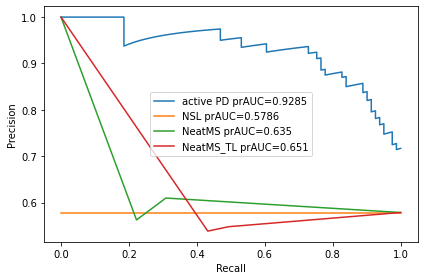

In [44]:
makePRCPlot(y_test_scores_active_syn[:,1],y_labeled[:,1],noSkill=True,label="active PD")
makePRCPlot(y_test_scores_neat_ms,y_labeled[:,1],noSkill=False,label="NeatMS")
makePRCPlot(y_test_scores_neat_ms_TL,y_labeled[:,1],noSkill=False,label="NeatMS_TL")

plt.tight_layout()
plt.savefig(datadir+"PRC_TL.png",dpi=300)

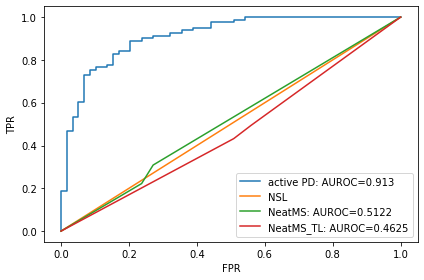

In [45]:
makeROCPlot(y_test_scores_active_syn[:,1],y_labeled[:,1],noSkill=True,label="active PD")
makeROCPlot(y_test_scores_neat_ms,y_labeled[:,1],noSkill=False,label="NeatMS")
makeROCPlot(y_test_scores_neat_ms_TL,y_labeled[:,1],noSkill=False,label="NeatMS_TL")

plt.tight_layout()
plt.savefig(datadir+"ROC_TL.png",dpi=300)

In [51]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=0.5)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
393/393 [==============================] - 1s 1ms/step


In [46]:
acc_results = pd.DataFrame.from_dict({"active PD":met.accuracy_score(y_labeled[:,1],y_test_scores_active_syn[:,1] > 0.5),
                                     "NeatMS":met.accuracy_score(y_labeled[:,1],y_test_scores_neat_ms > 0.25),
                                     "NeatMS TL:":met.accuracy_score(y_labeled[:,1],y_test_scores_neat_ms_TL > 0.25)},orient="index")
acc_results.to_csv(datadir + "accuracy_results.csv")

In [47]:
acc_results

,0
active PD,0.685714
NeatMS,0.485714
NeatMS TL:,0.471429


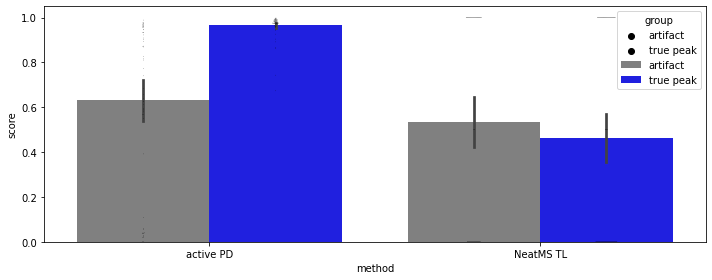

In [48]:
plt_df = {}
for x in range(len(y_labeled)):
    if y_labeled[x][1] > 0.5:
        plt_df[len(plt_df)] = {"method":"active PD","group":"true peak","score":y_test_scores_active_syn[x][1]}
        #plt_df[len(plt_df)] = {"method":"NeatMS","group":"true peak","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"NeatMS TL","group":"true peak","score":y_test_scores_neat_ms_TL[x]}

    else:
        plt_df[len(plt_df)] = {"method":"active PD","group":"artifact","score":y_test_scores_active_syn[x][1]}
        #plt_df[len(plt_df)] = {"method":"NeatMS","group":"artifact","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"NeatMS TL","group":"artifact","score":y_test_scores_neat_ms_TL[x]}

plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
plt.figure(figsize=(10,4))
#sb.violinplot(data=plt_df,x="method",y="score",hue="group",cut=0,palette={"true peak":"blue","artifact":"grey"})
sb.barplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"blue","artifact":"grey"})
sb.swarmplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"black","artifact":"black"},dodge=True,s=0.5)
plt.tight_layout()
plt.savefig(datadir+"bar_TL.png",dpi=300)

In [41]:
y = integ.classifyMatrix(X)

8342/8342 [==============================] - 11s 1ms/step


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


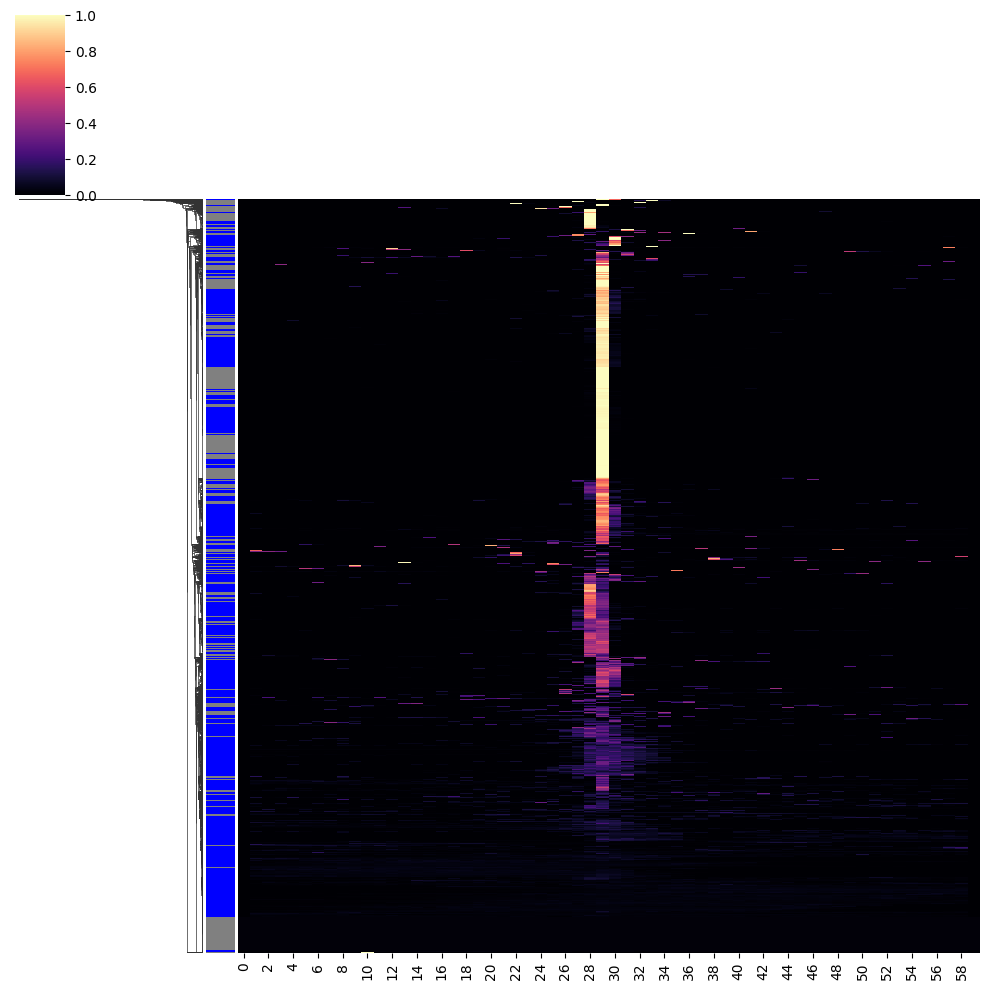

In [42]:
def tmp(val):
    if val > 0.5:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:len(peakList),1]]
sb.clustermap(PeakDetective.normalizeMatrix(X[:len(peakList)]),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)

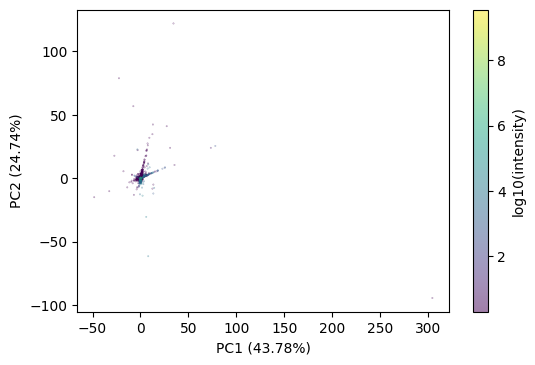

In [43]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))
plt.colorbar(label="log10(intensity)")

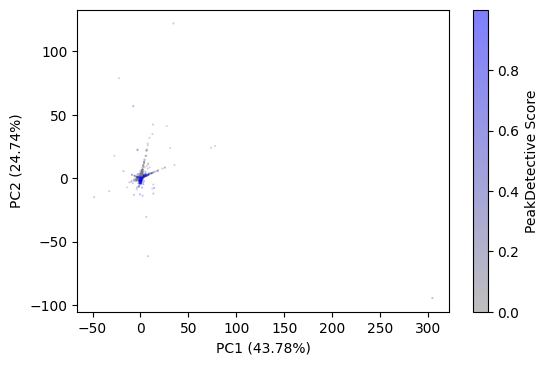

In [44]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))

plt.colorbar(label="PeakDetective Score")

Text(0, 0.5, '% of features')

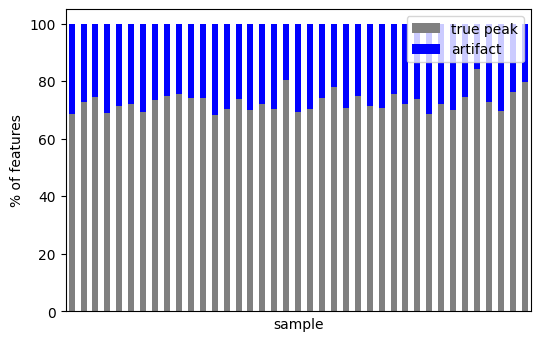

In [45]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > 0.5:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['sample10_dilution_1_2.mzML', 'sample11_dilution_100.mzML', 'sample12_dilution_7_5.mzML', 'sample13_dilution_1_8.mzML', 'sample14_dilution_3.mzML', 'sample15_dilution_15.mzML', 'sample16_dilution_50.mzML', 'sample17_dilution_20.mzML', 'sample18_dilution_50.mzML', 'sample19_dilution_5.mzML', 'sample1_dilution_1_4.mzML', 'sample20_dilution_1_6.mzML', 'sample21_dilution_100.mzML', 'sample22_dilution_7_5.mzML', 'sample23_dilution_2.mzML', 'sample24_dilution_50.mzML', 'sample25_dilution_10.mzML', 'sample26_dilution_1_2.mzML', 'sample27_dilution_2.mzML', 'sample28_dilution_15.mzML', 'sample29_dilution_10.mzML', 'sample2_dilution_5.mzML', 'sample30_dilution_100.mzML', 'sample31_dilution_1_6.mzML', 'sample32_dilution_1_8.mzML', 'sample33_dilution_1_2.mzML', 'sample34_dilution_20.mzML', 'sample35_dilution_7_5.mzML', 'sample36_dilution_1_4.mzML', 'sample37_dilution_1_8.mzML', 'sample38_dilution_3.mzML', 'sample39_dilution_2.mzML', 'sample3_dilution_20.mzML', 'sample40_dilution_3.mzML', 'sample4

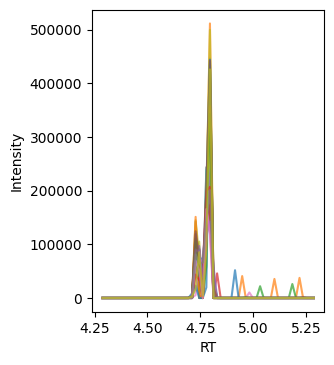

In [46]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

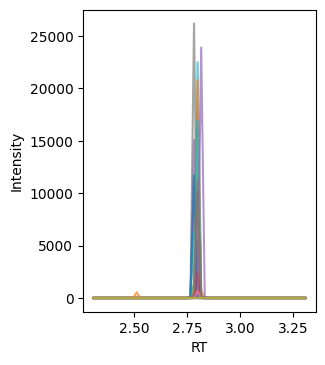

In [47]:
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [54]:
print(confusion_matrix(y_labeled[:,1],y_test_scores_neat_ms > 0.5))
print(met.accuracy_score(y_labeled[:,1],y_test_scores_neat_ms > 0.5))

[[16 13]
 [13 74]]
0.7758620689655172


In [55]:
print(confusion_matrix(y_labeled[:,1],y_test_scores_active_syn[:,1] > 0.5))
print(met.accuracy_score(y_labeled[:,1],y_test_scores_active_syn[:,1] > 0.5))

[[ 5 24]
 [24 63]]
0.5862068965517241


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


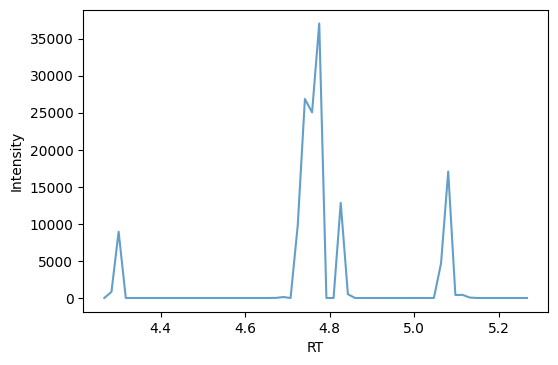

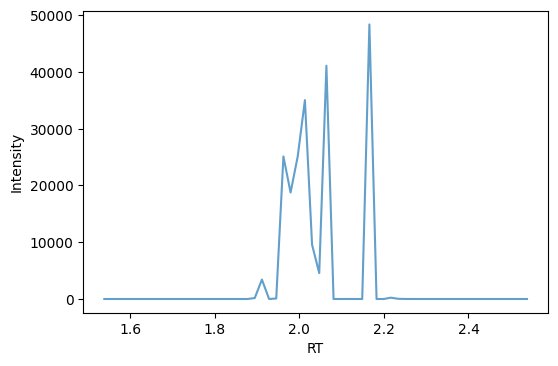

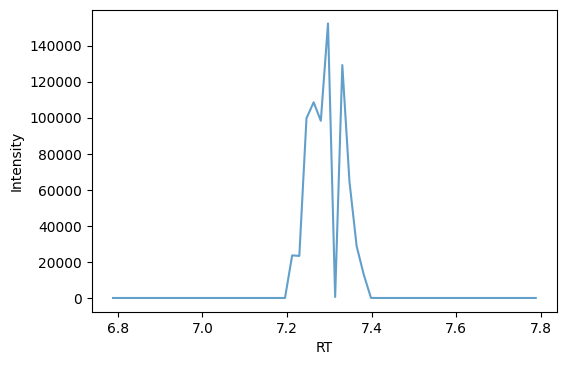

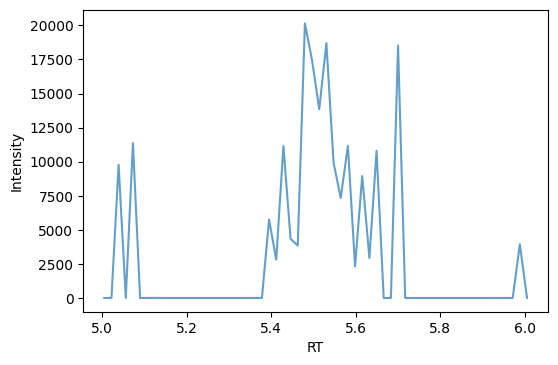

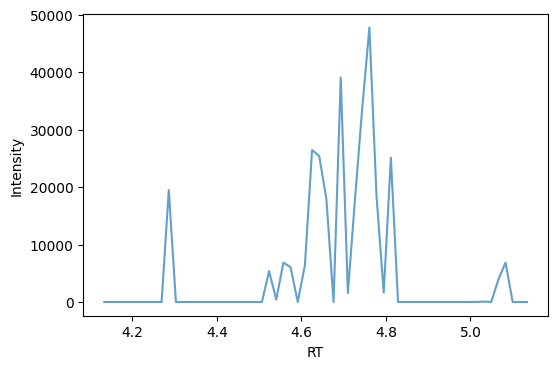

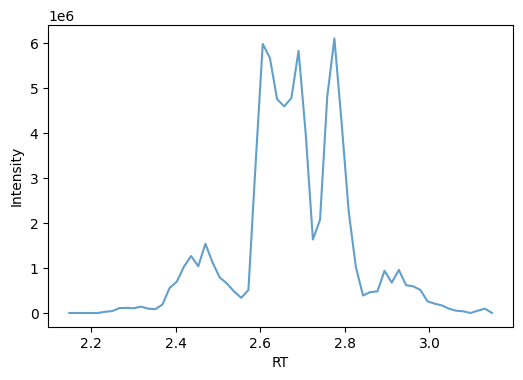

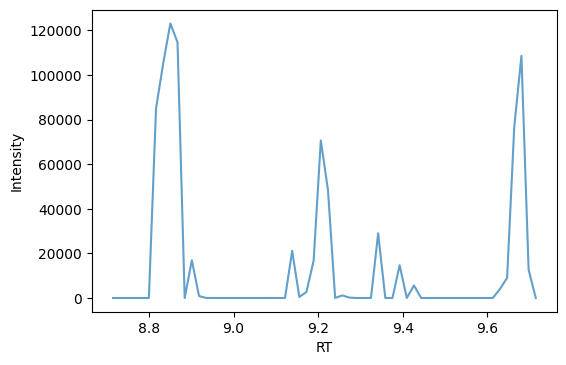

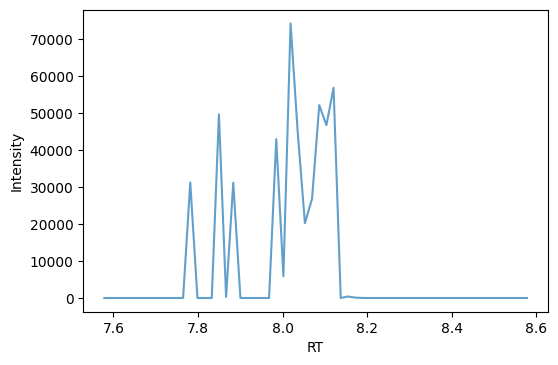

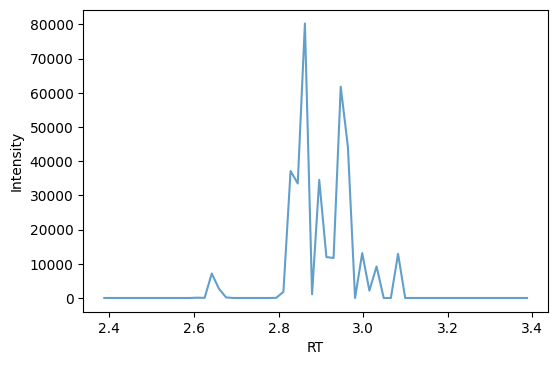

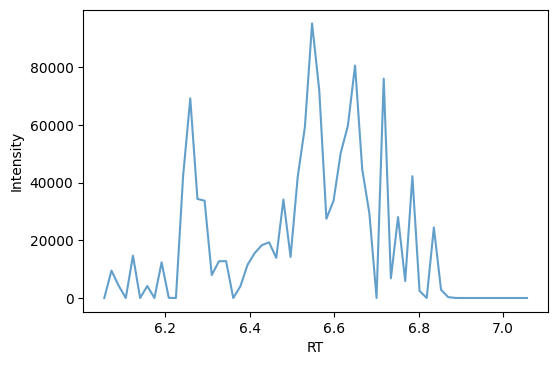

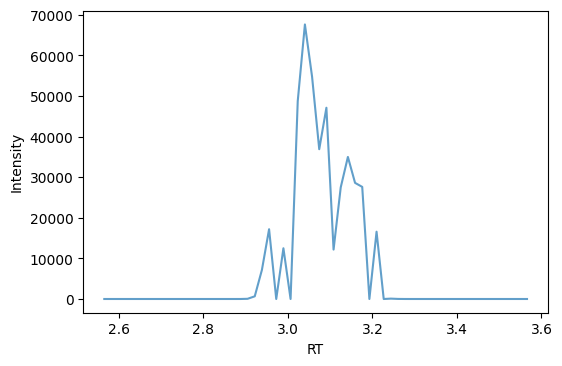

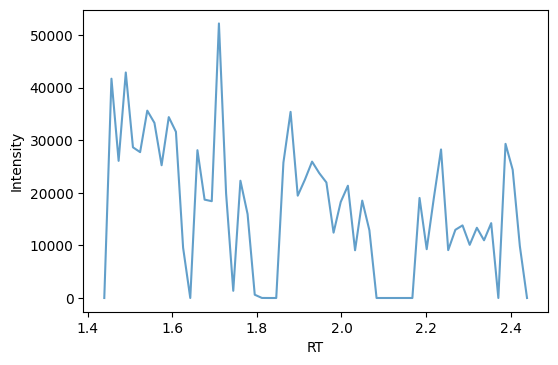

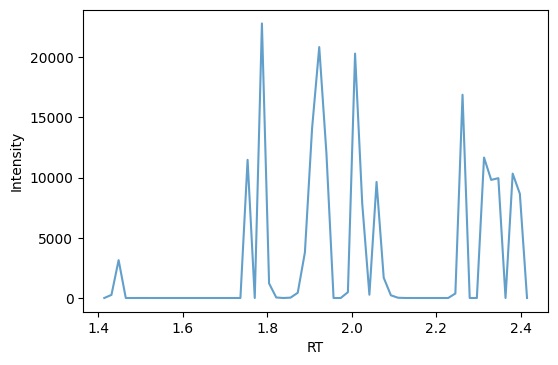

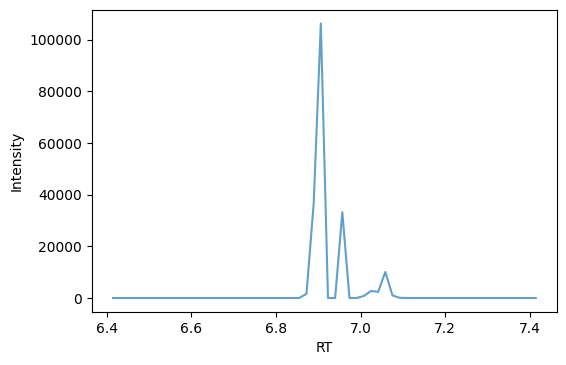

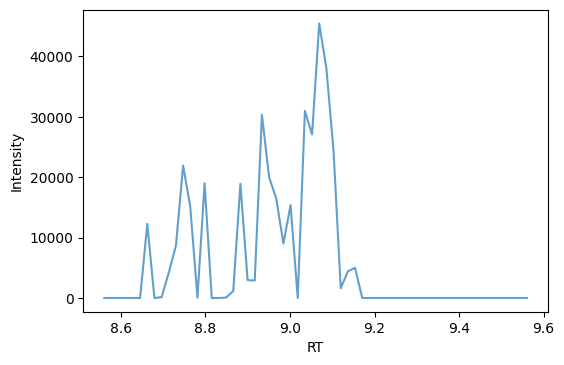

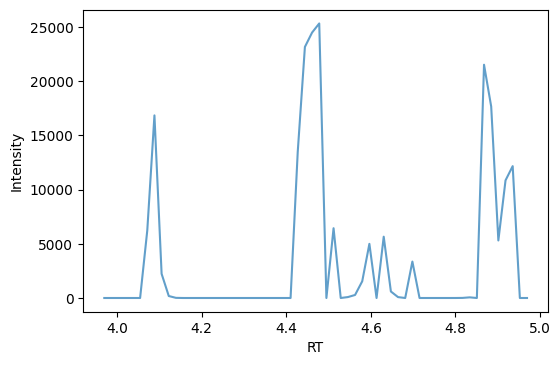

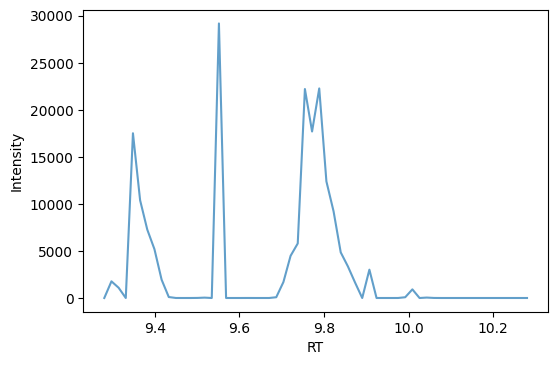

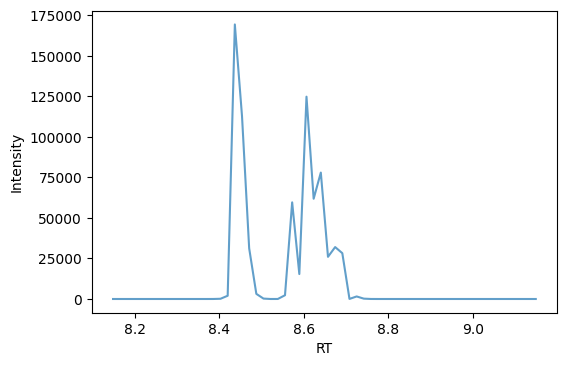

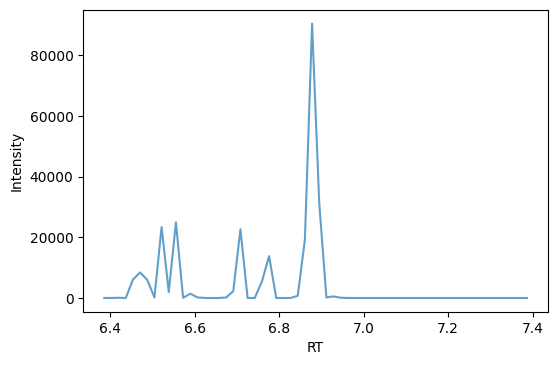

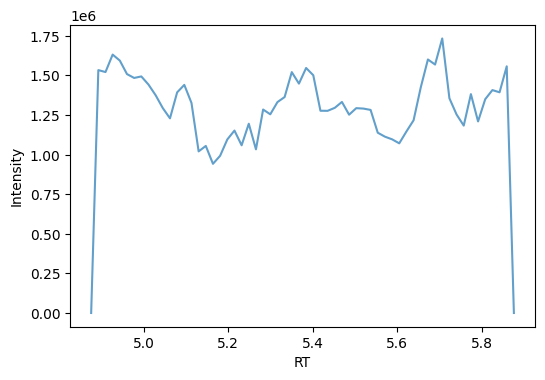

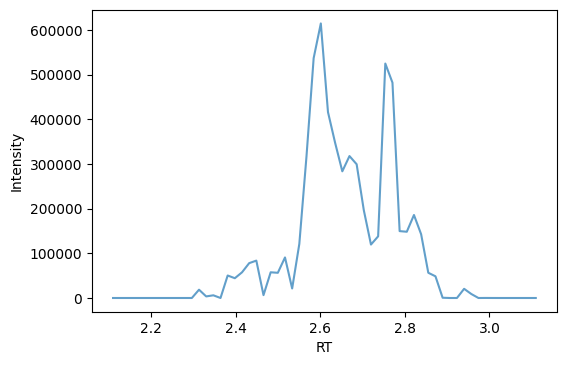

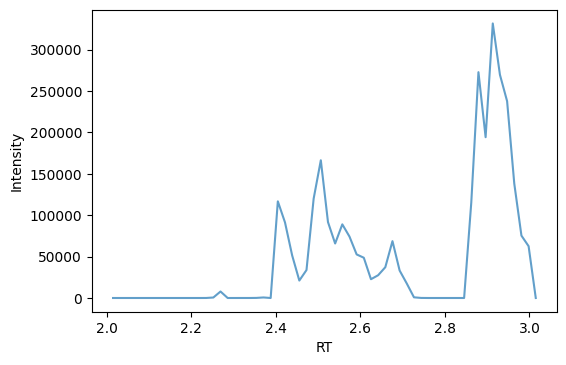

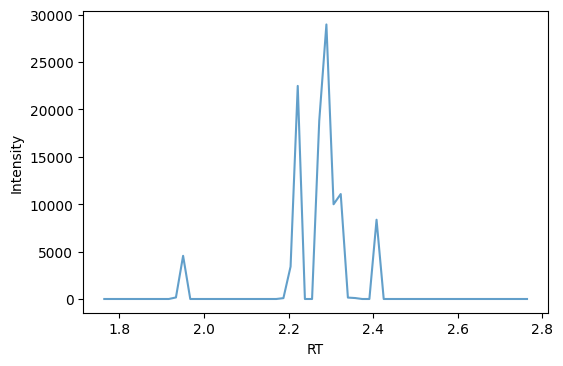

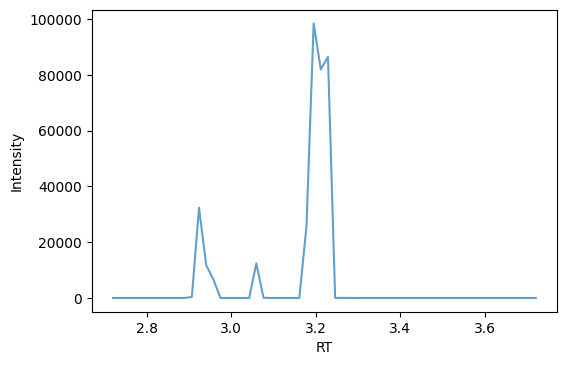

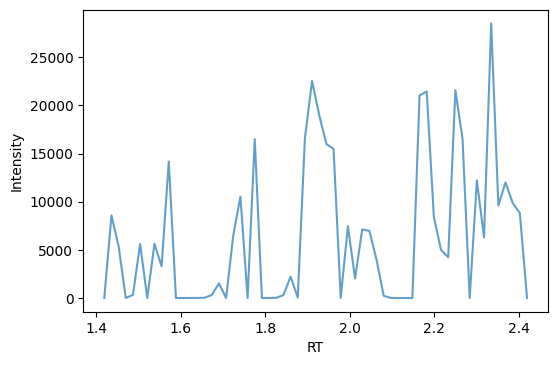

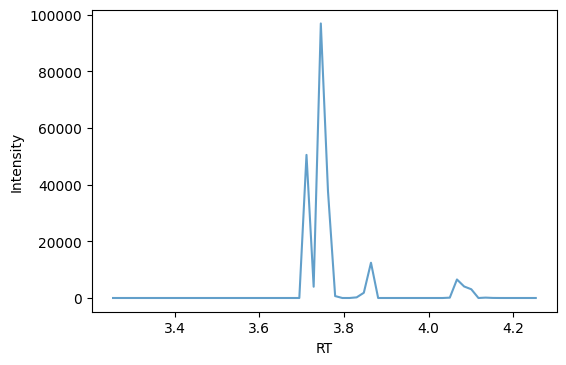

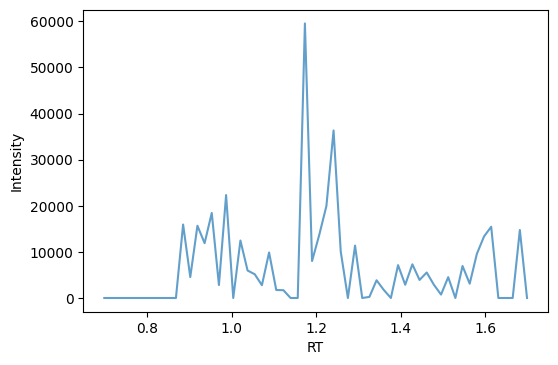

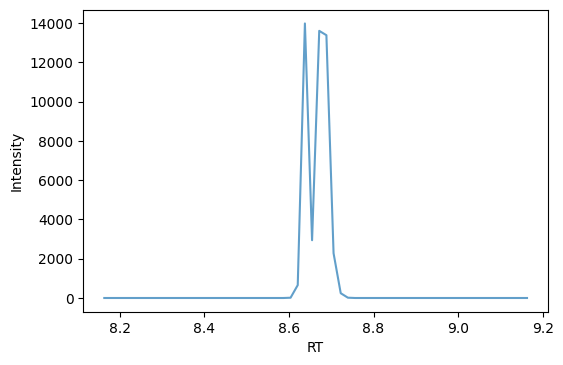

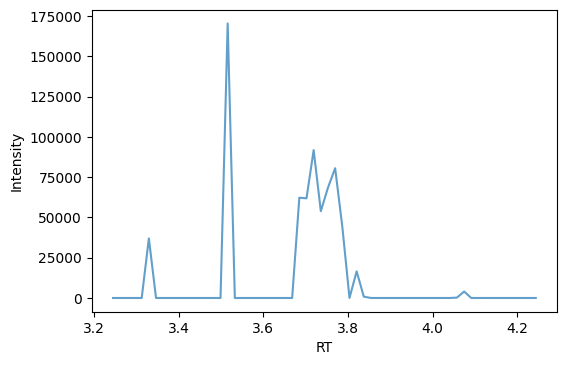

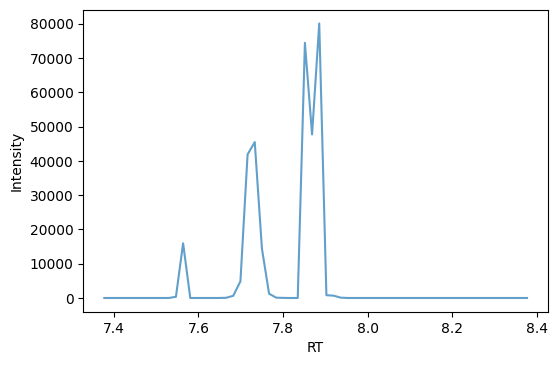

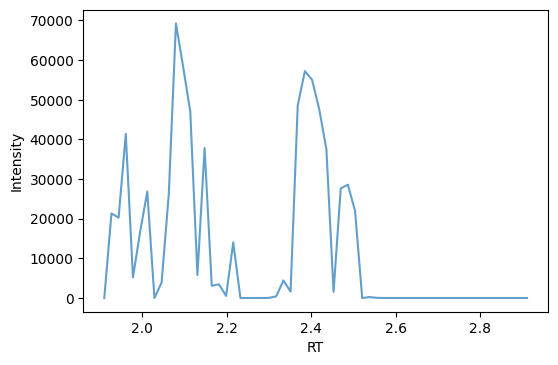

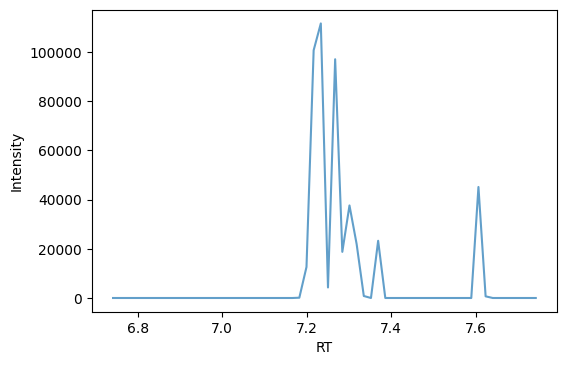

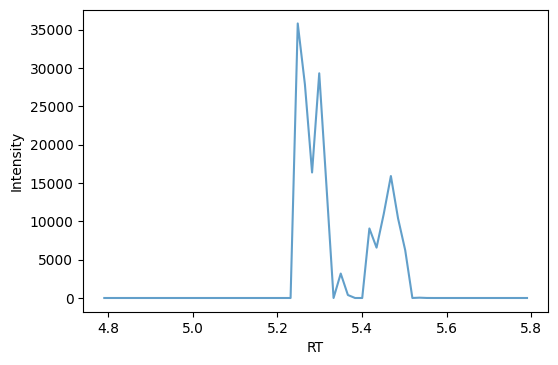

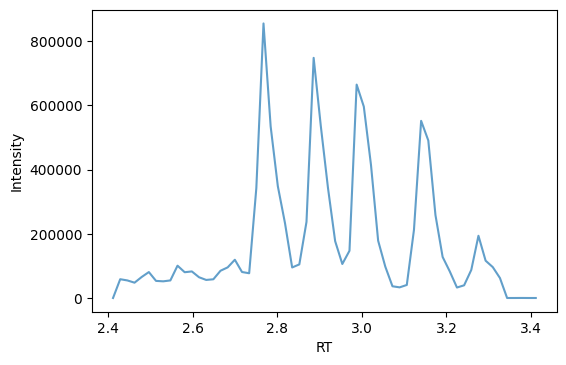

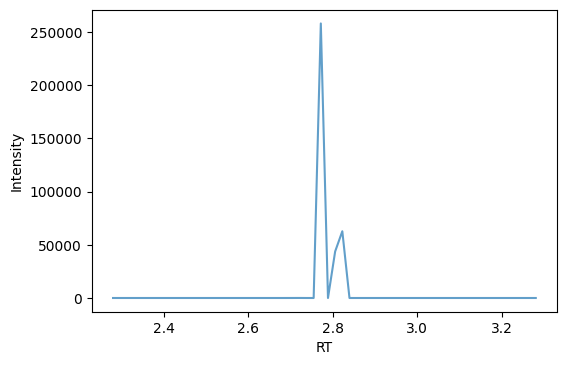

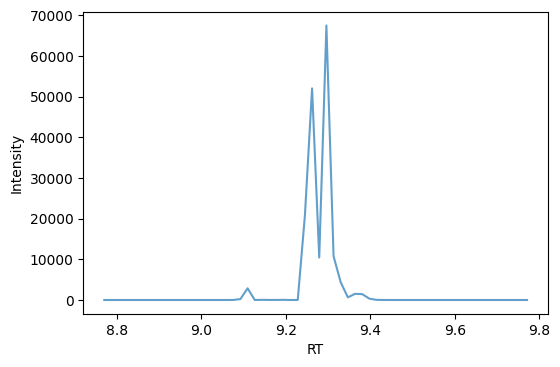

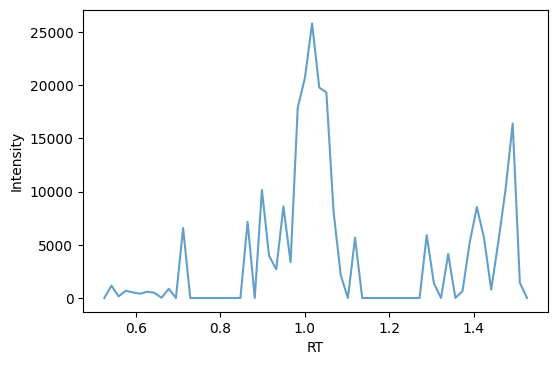

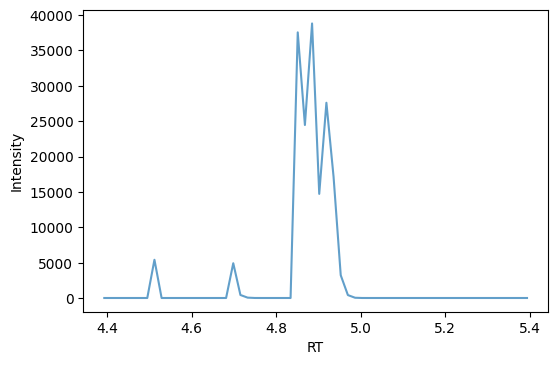

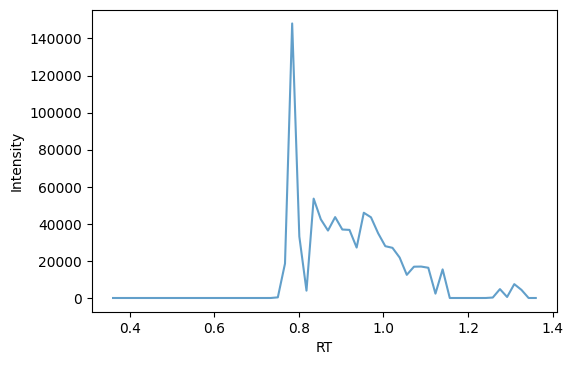

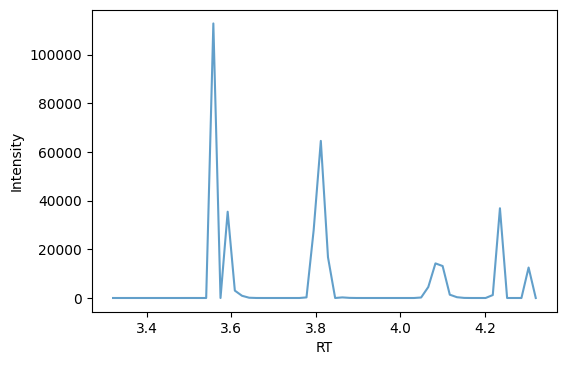

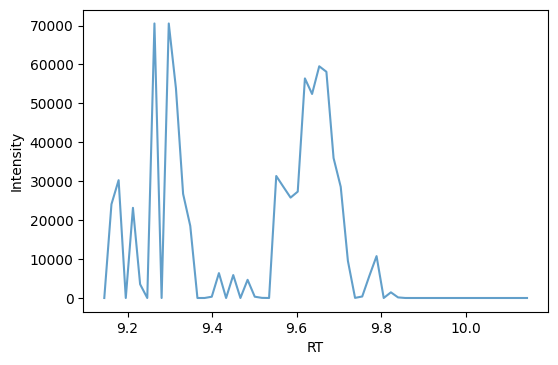

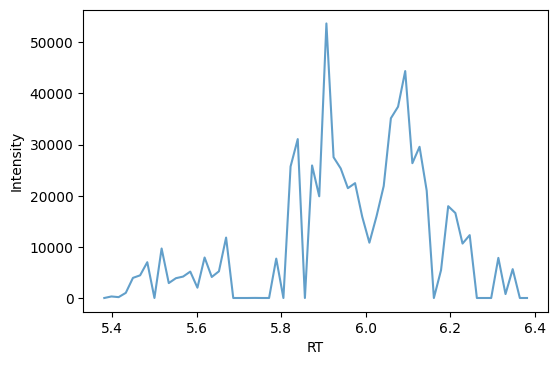

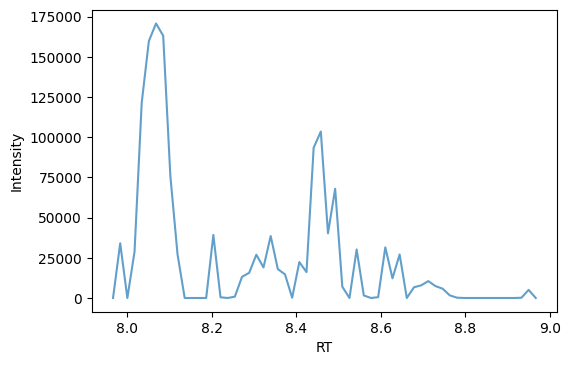

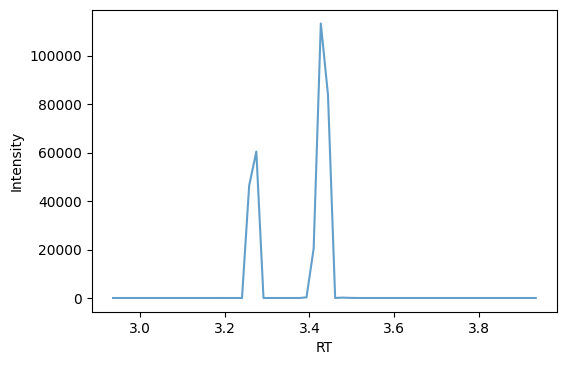

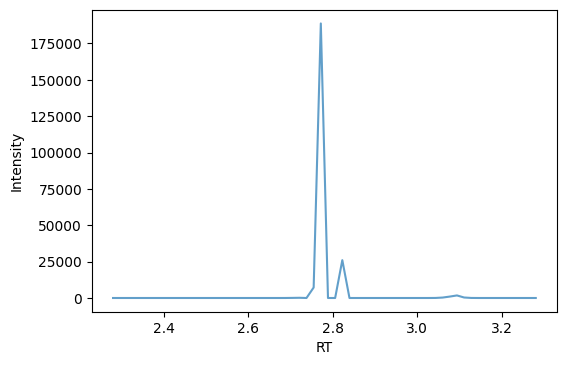

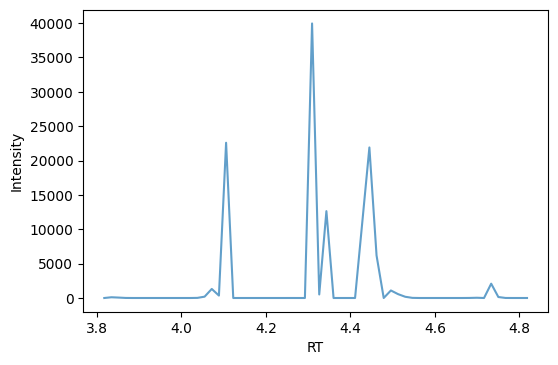

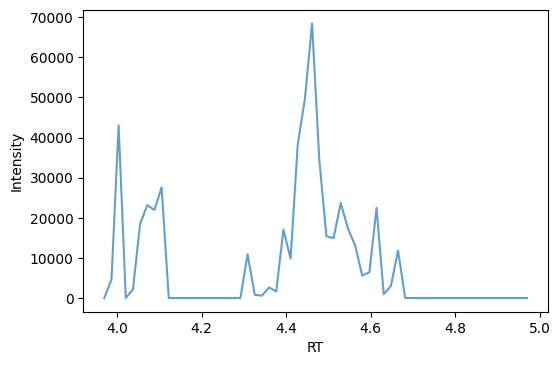

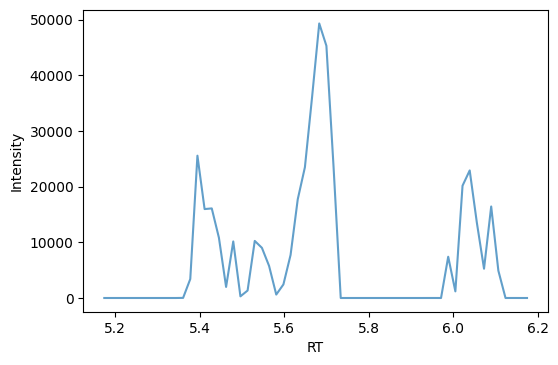

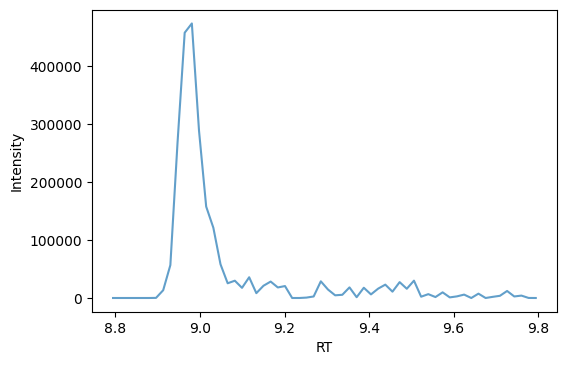

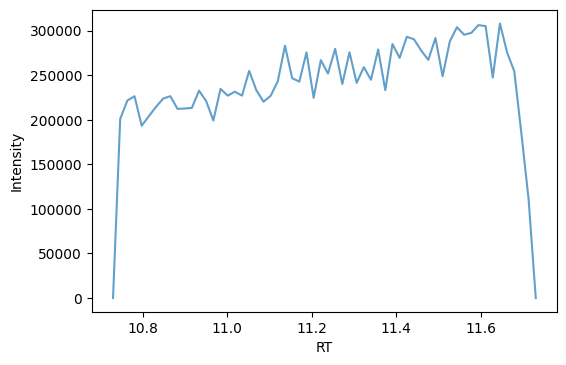

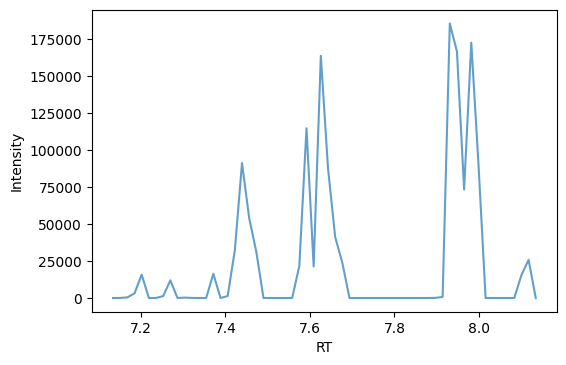

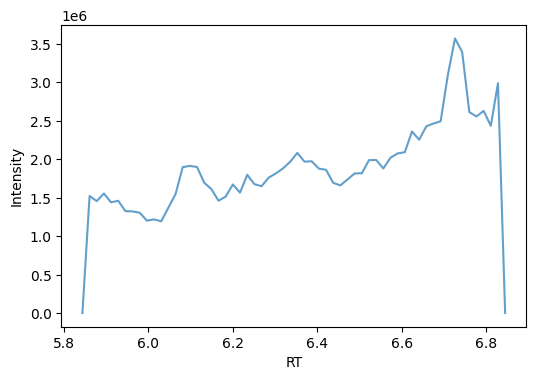

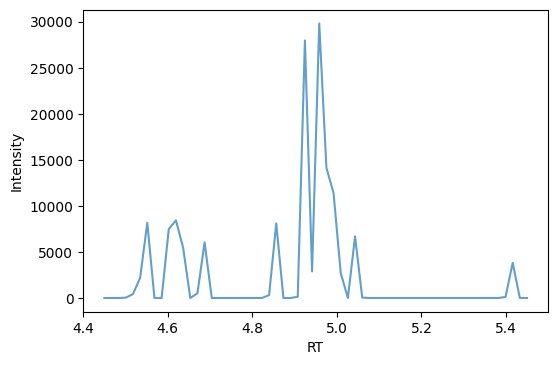

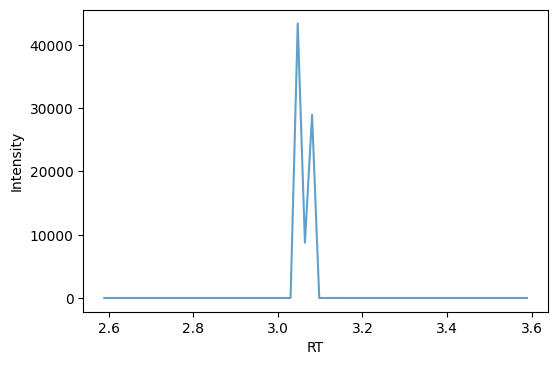

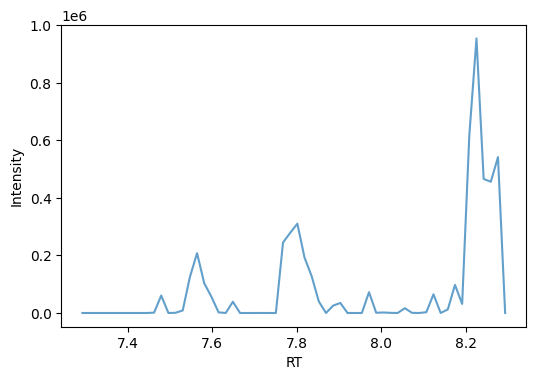

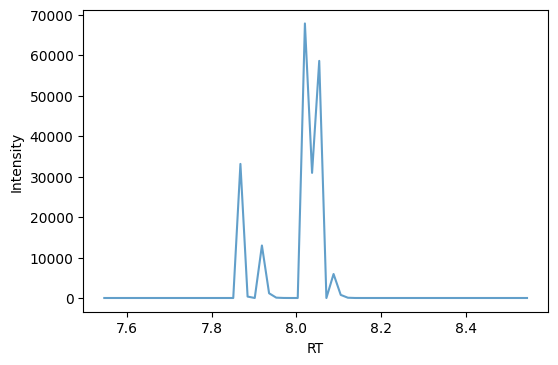

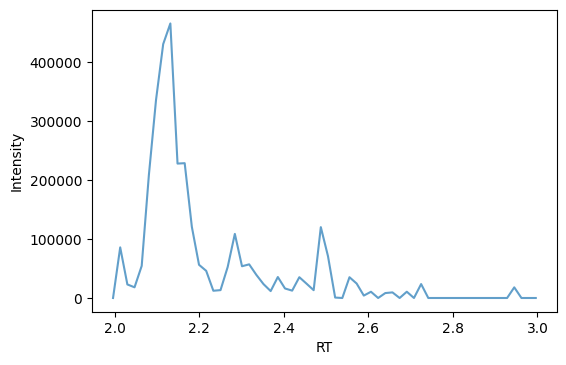

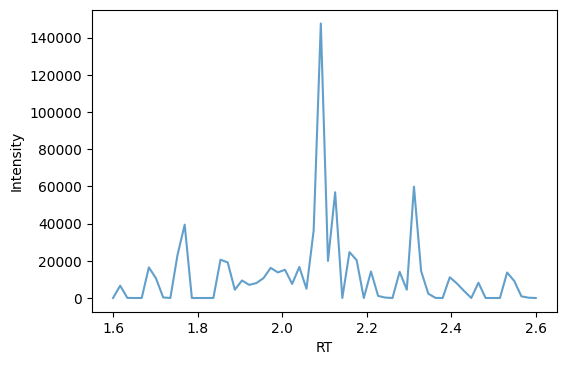

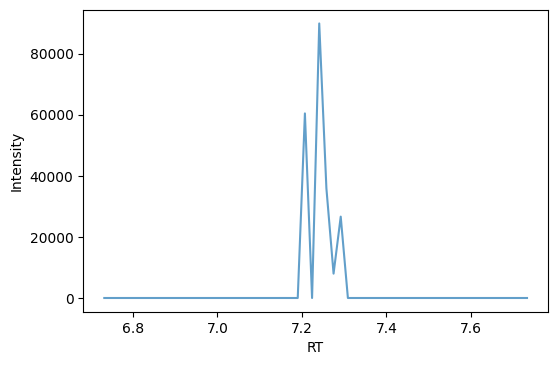

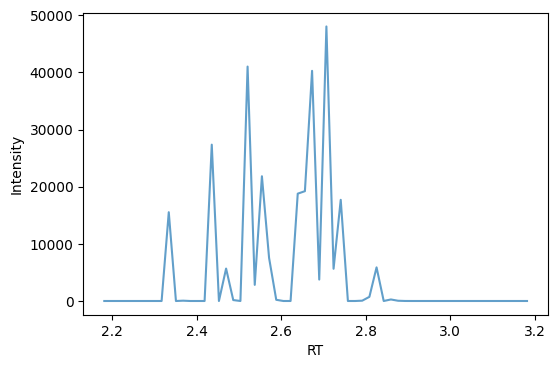

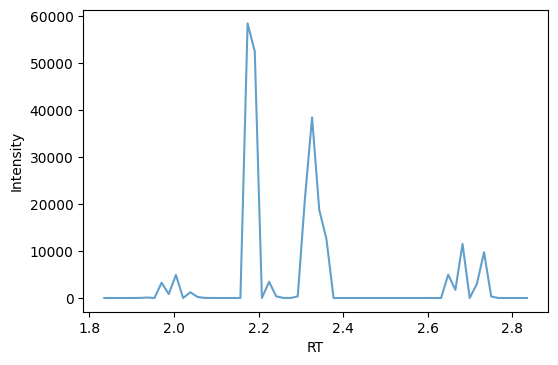

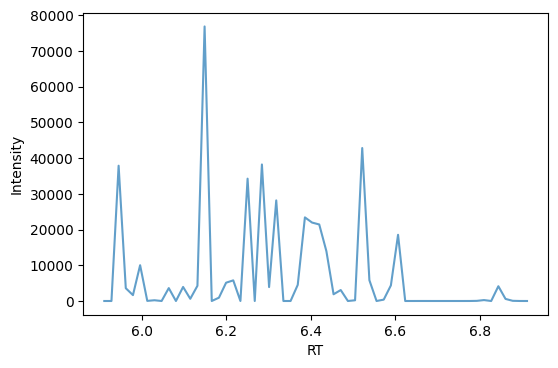

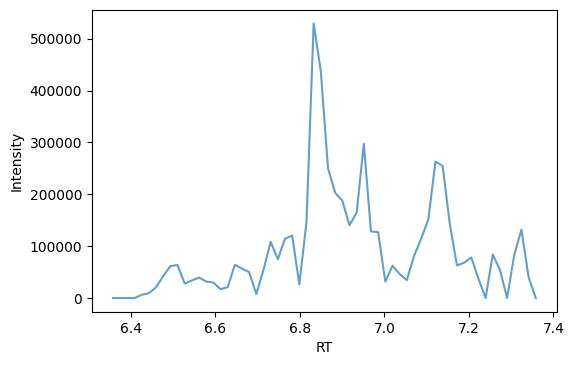

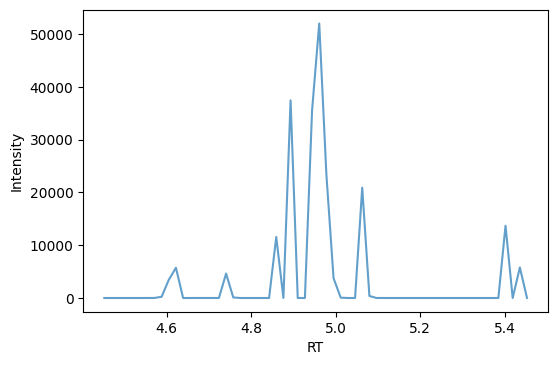

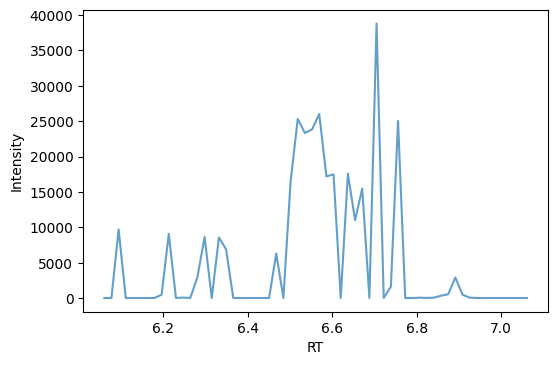

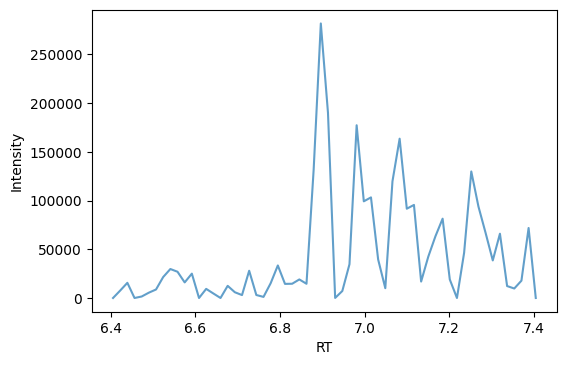

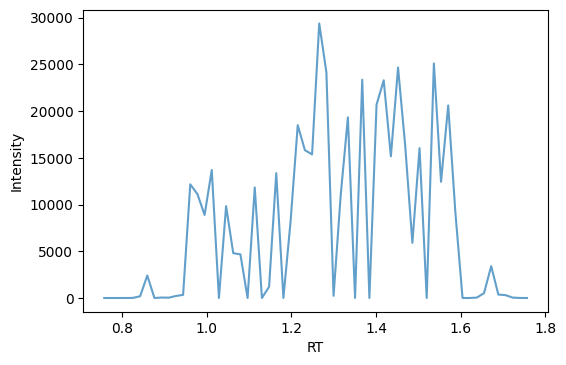

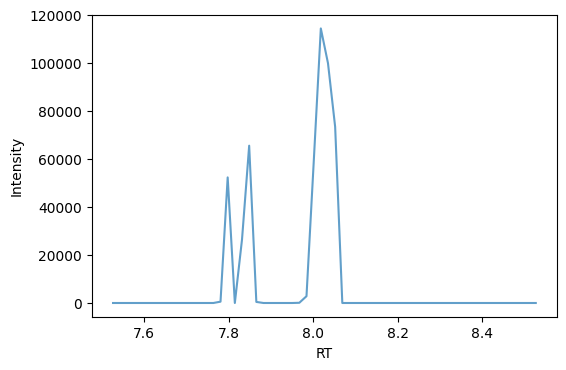

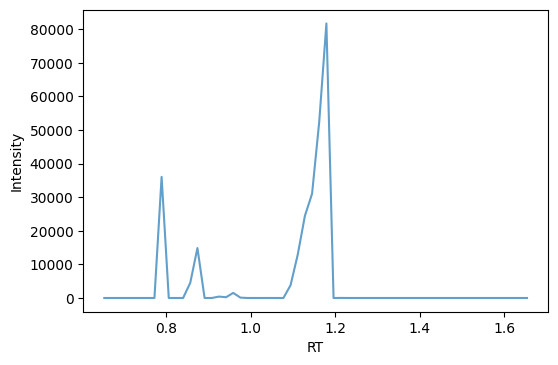

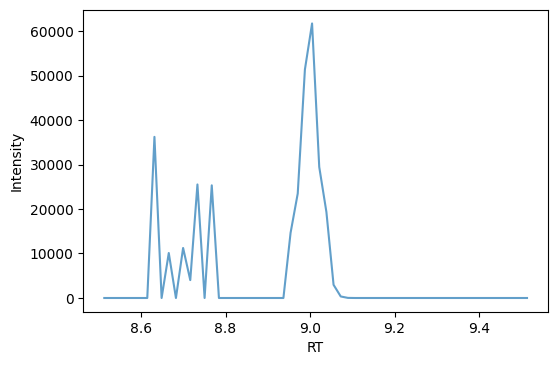

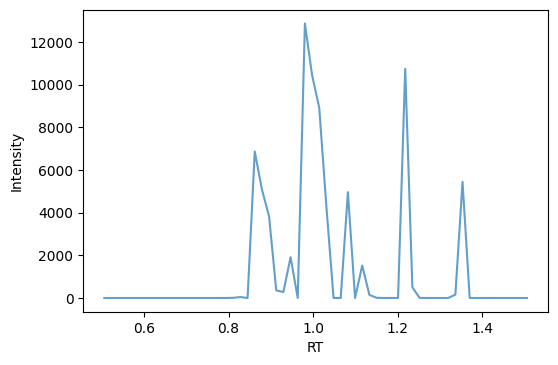

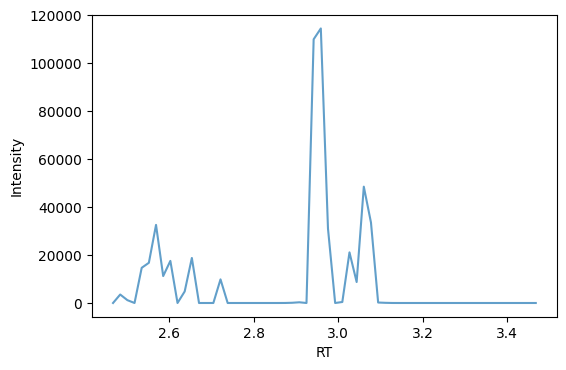

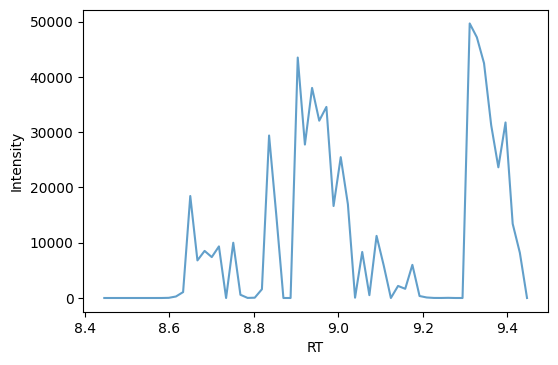

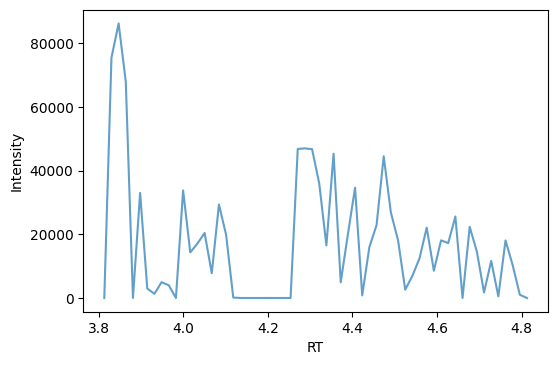

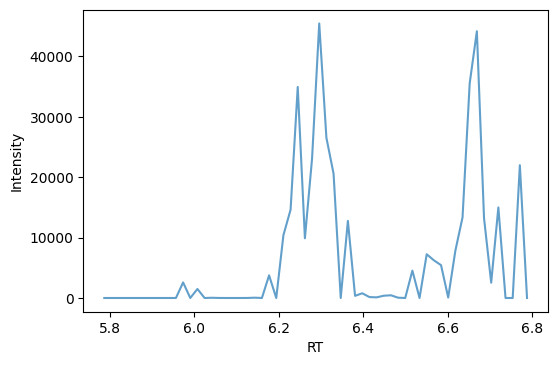

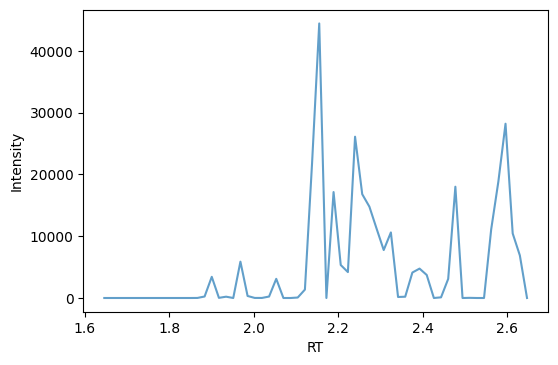

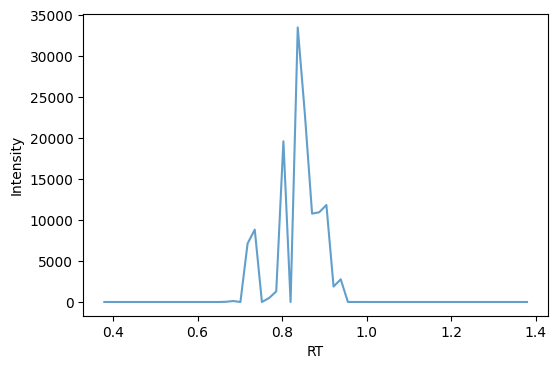

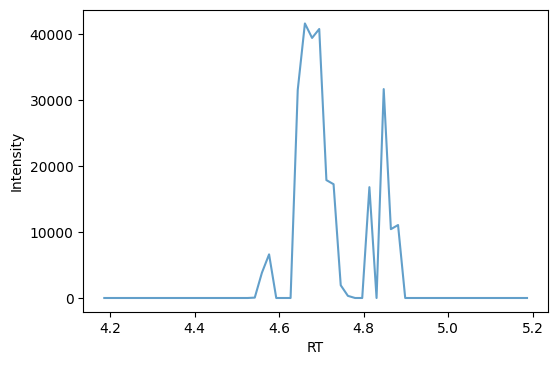

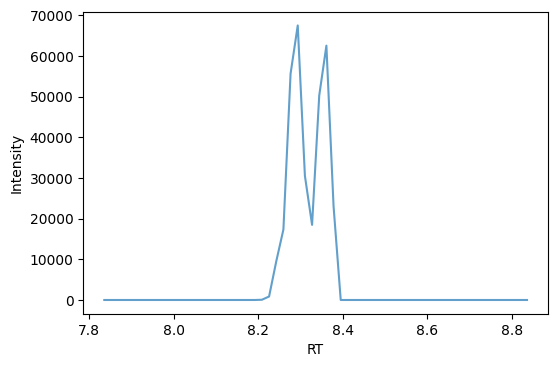

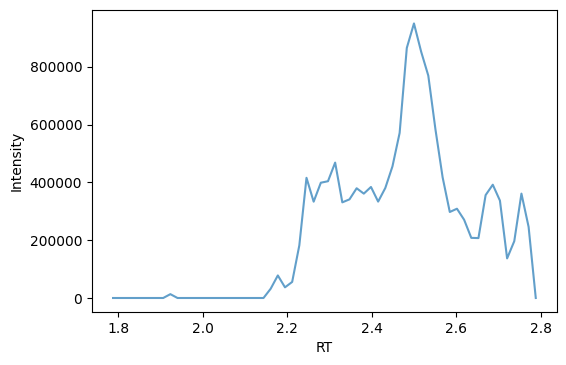

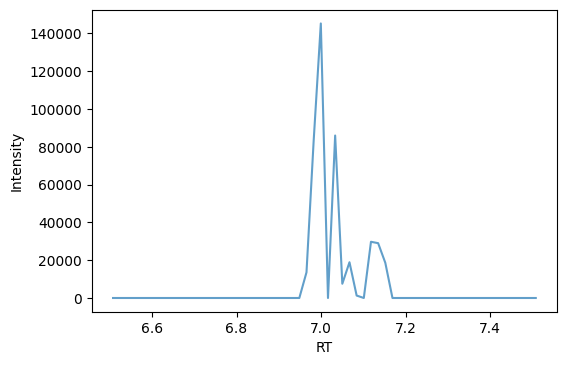

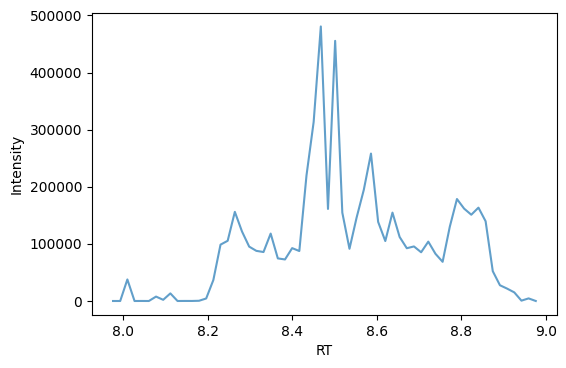

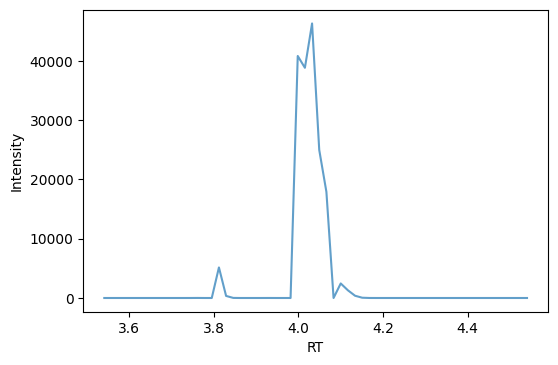

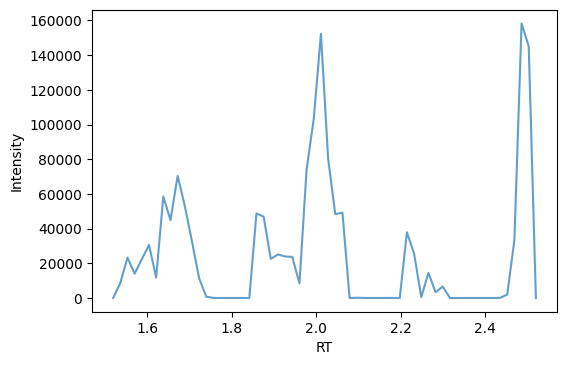

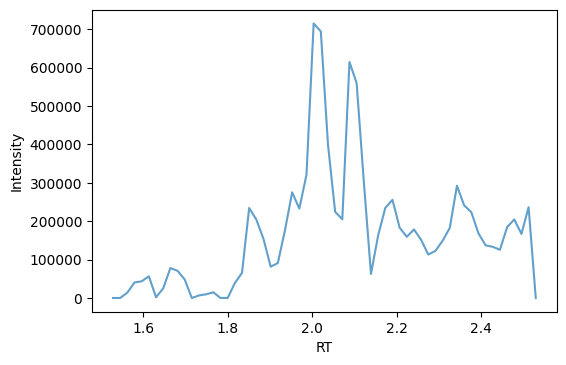

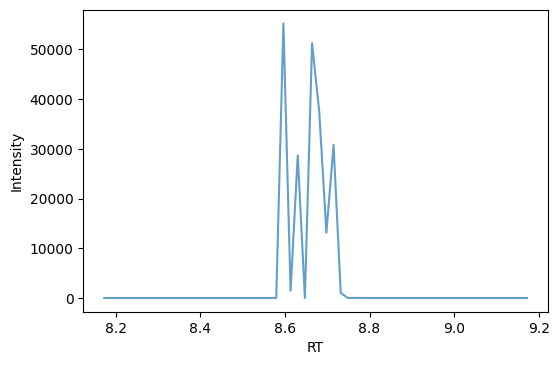

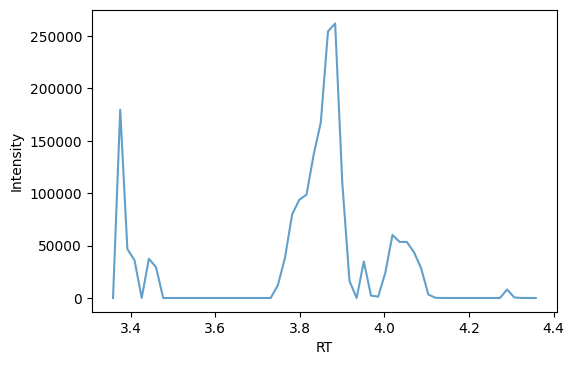

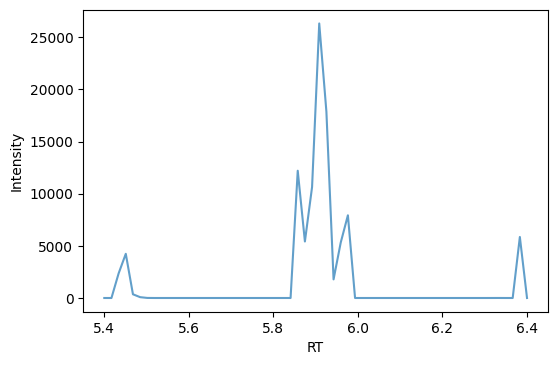

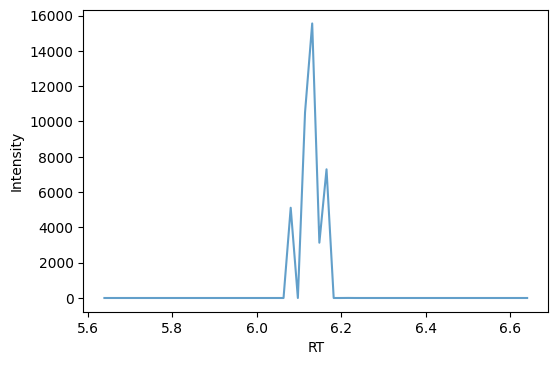

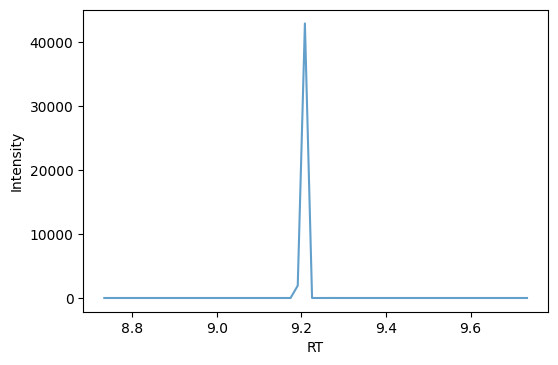

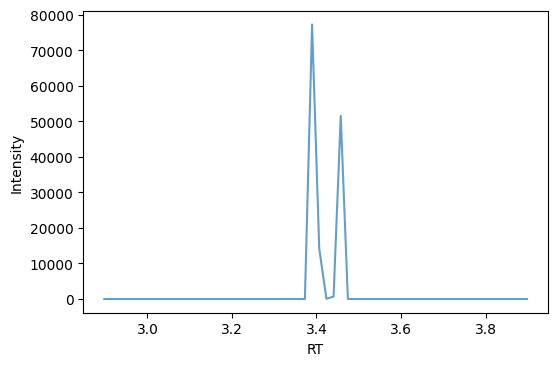

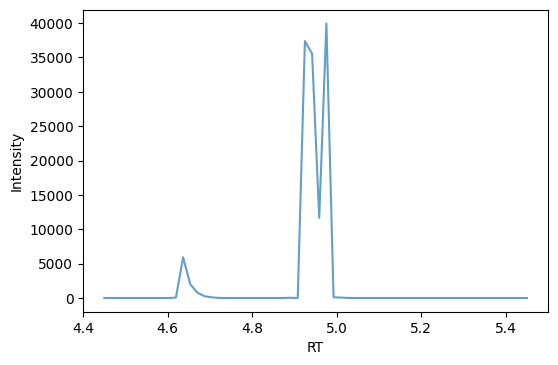

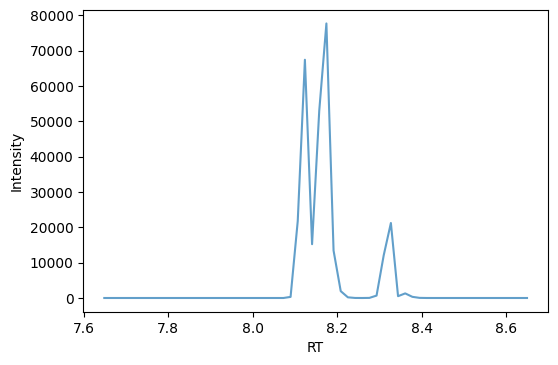

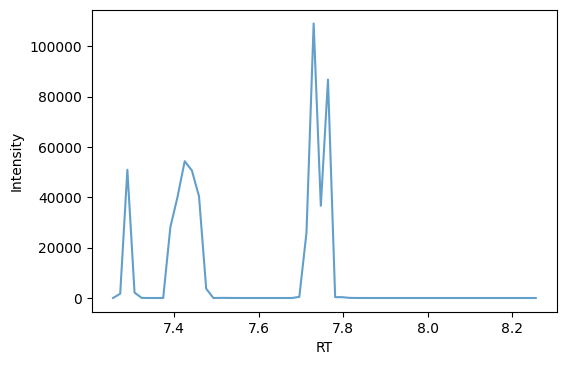

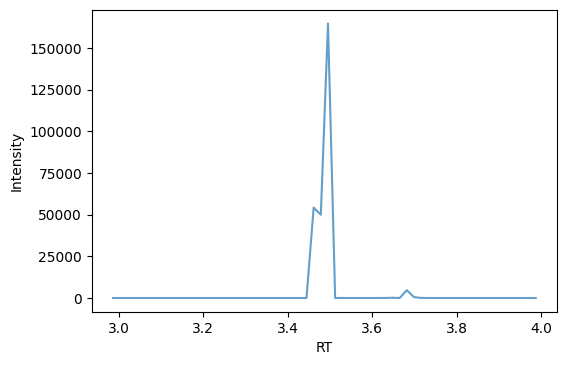

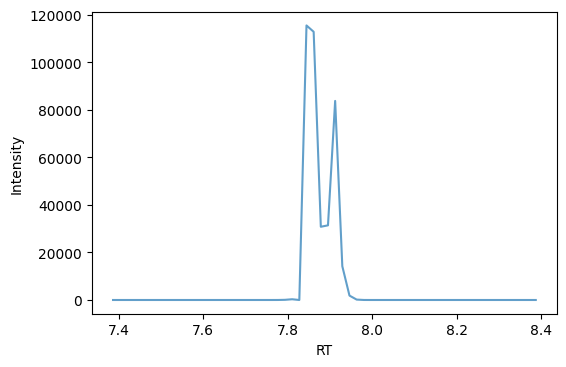

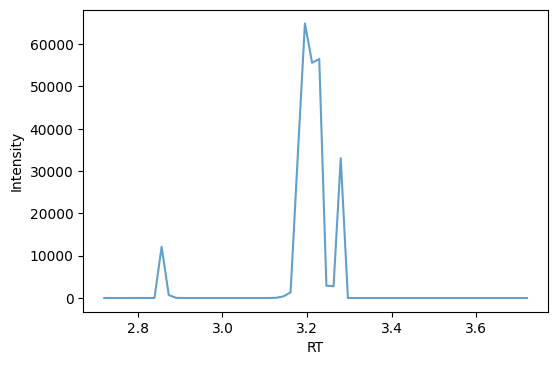

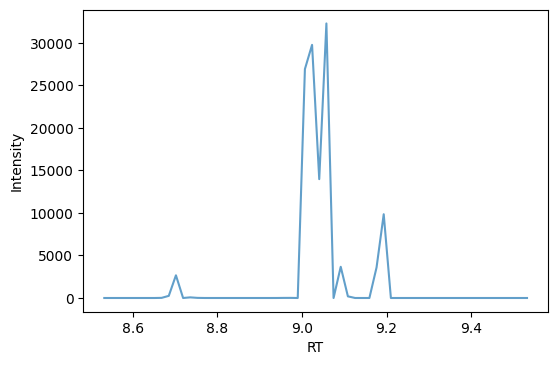

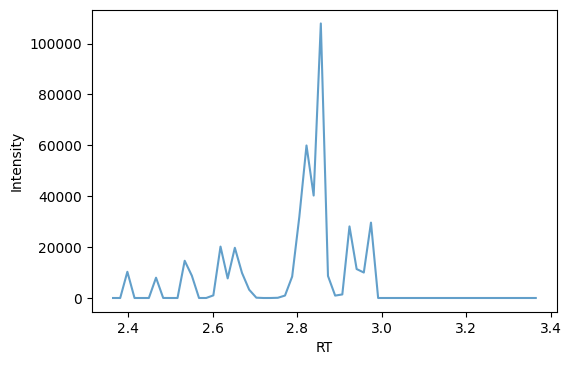

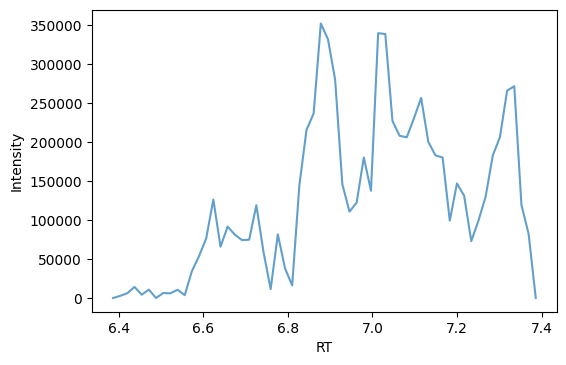

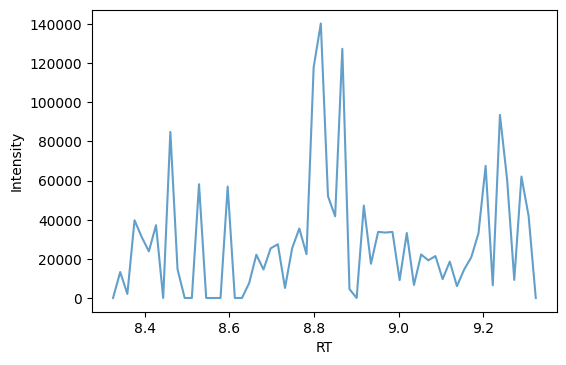

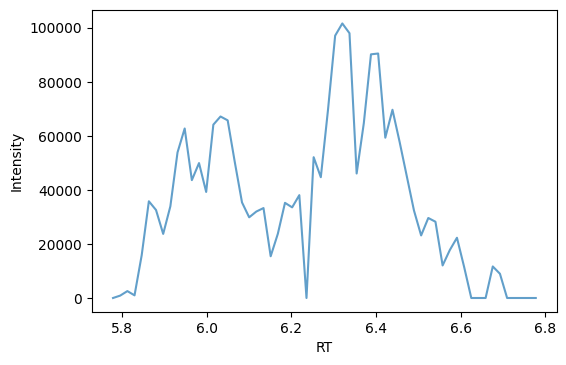

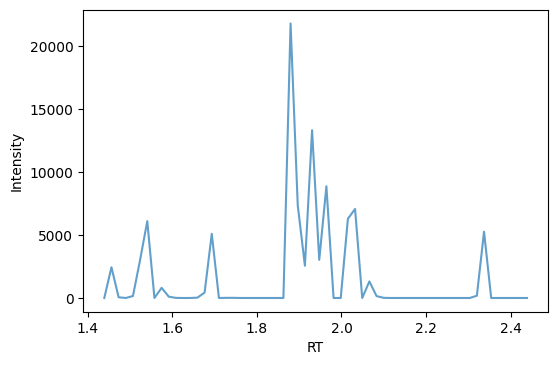

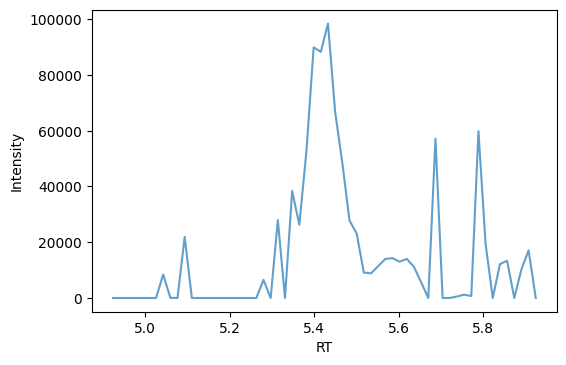

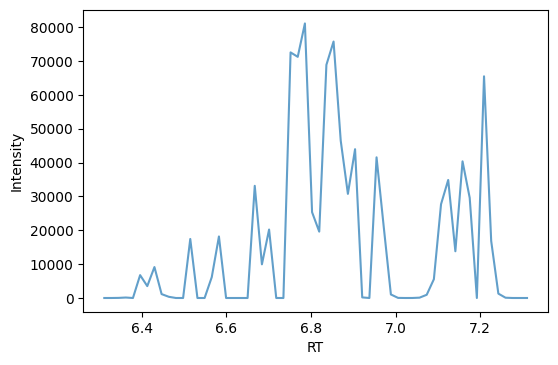

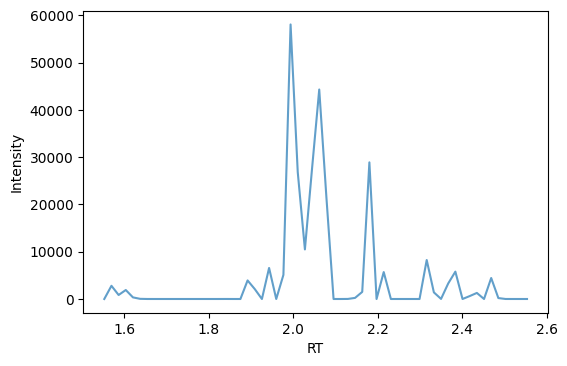

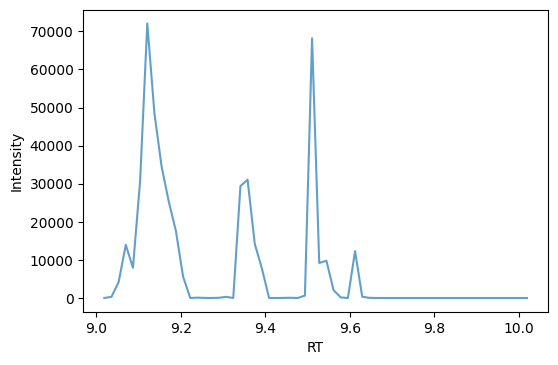

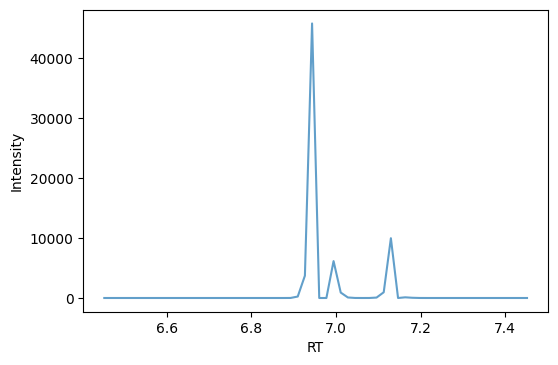

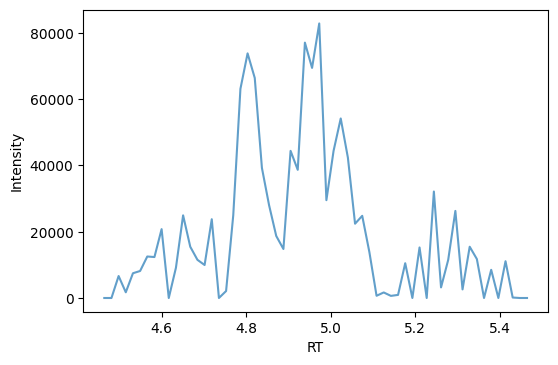

<Figure size 600x400 with 0 Axes>

In [124]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


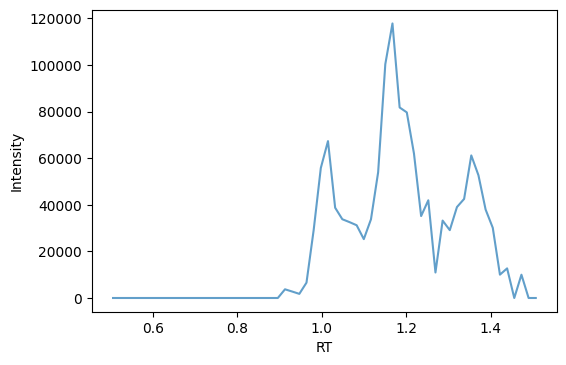

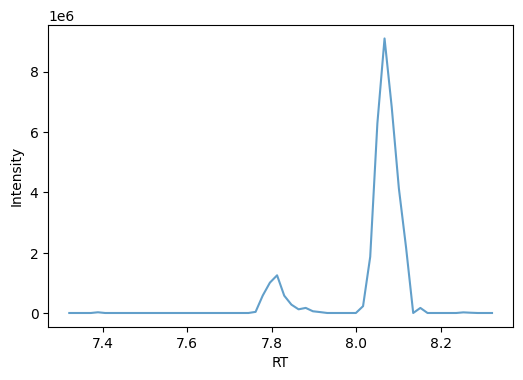

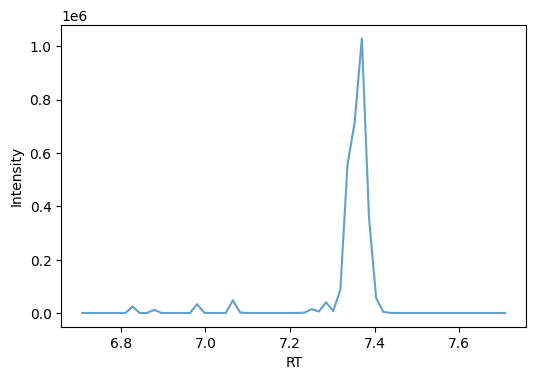

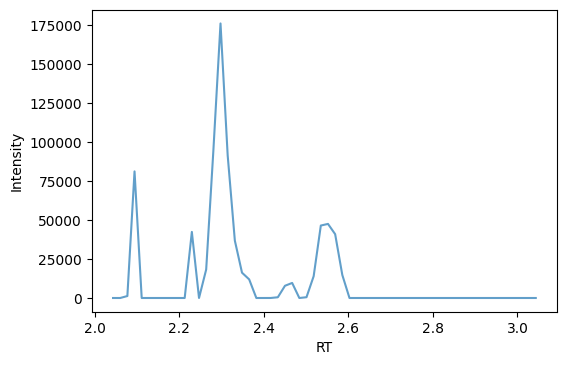

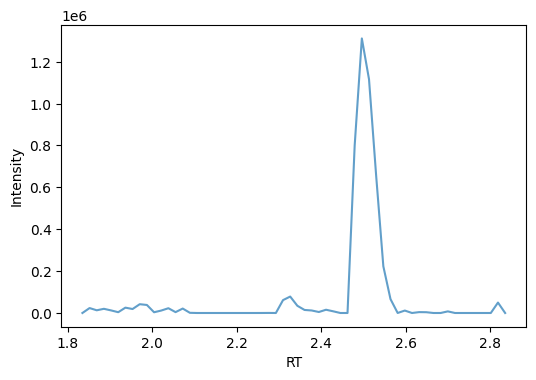

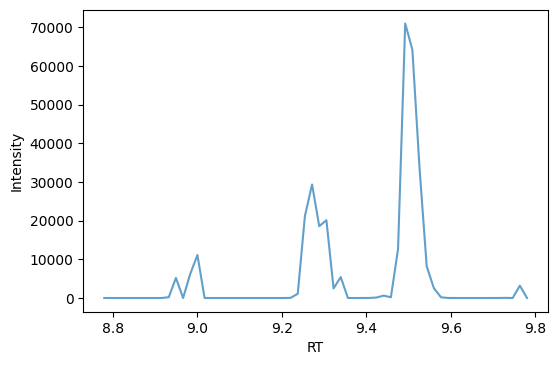

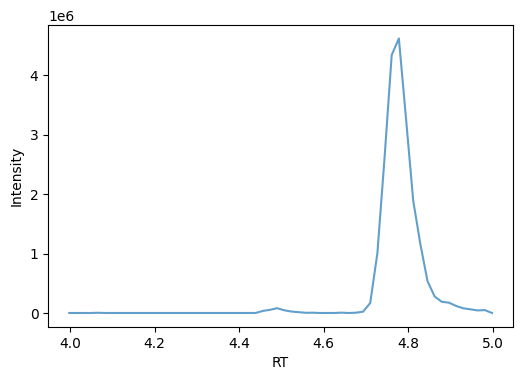

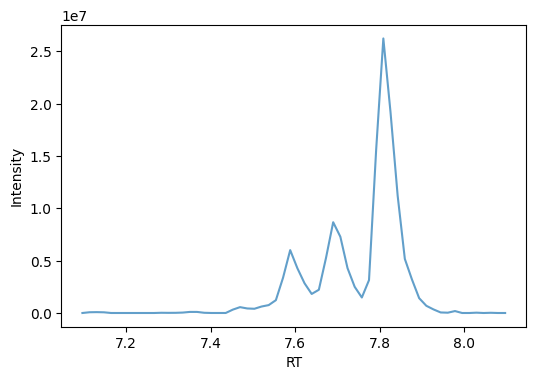

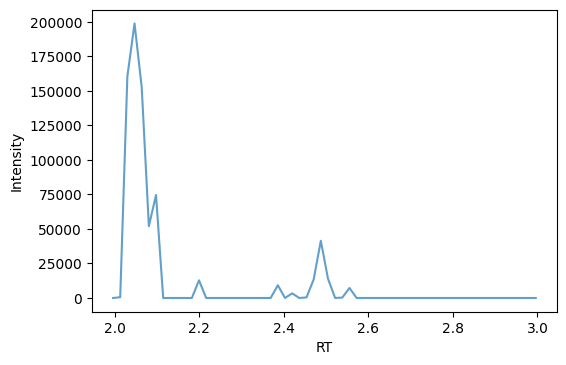

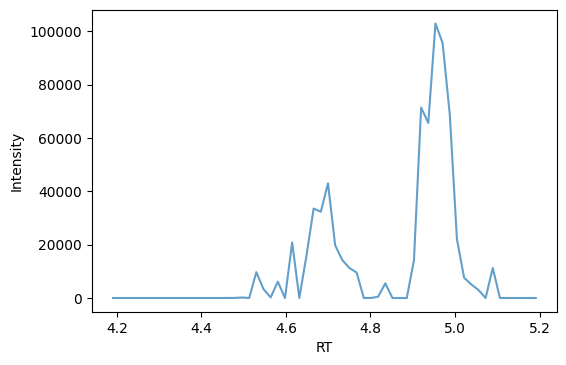

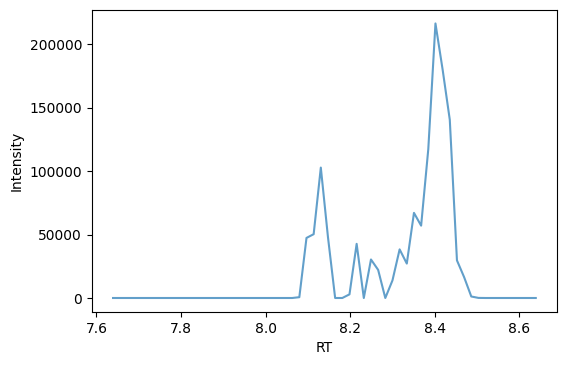

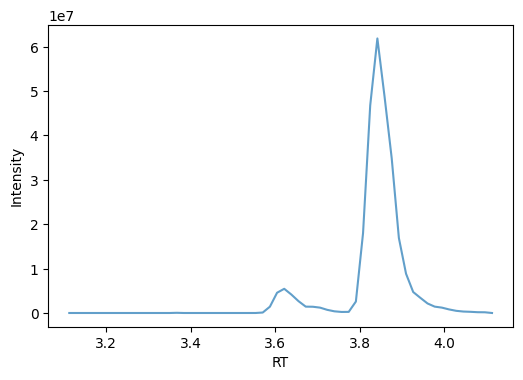

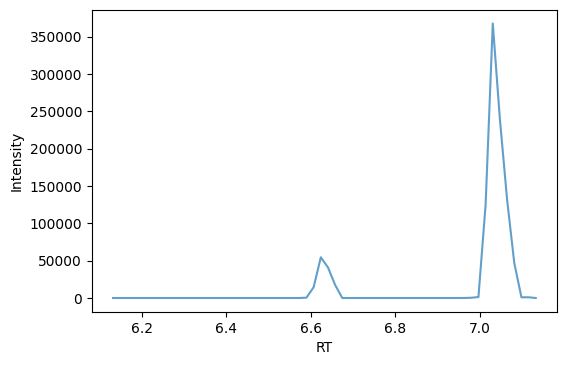

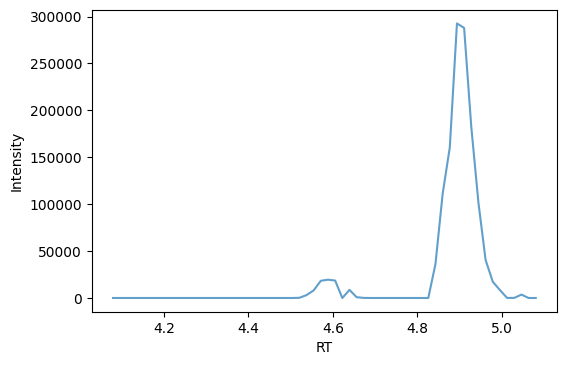

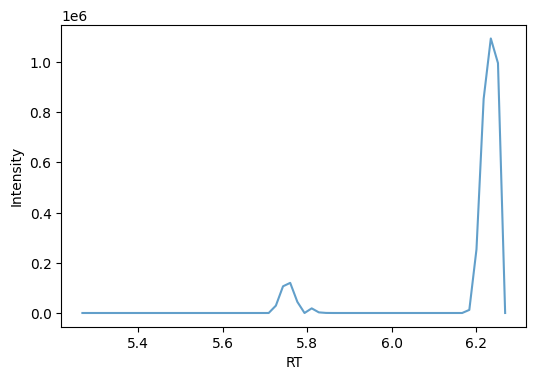

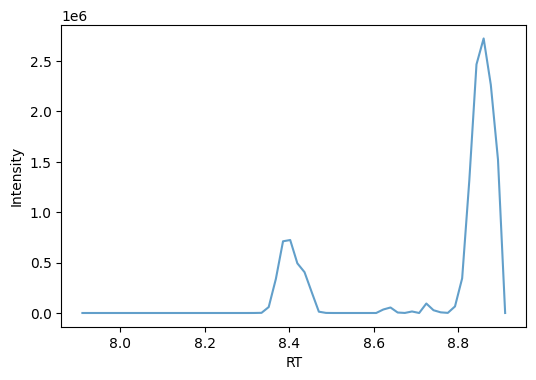

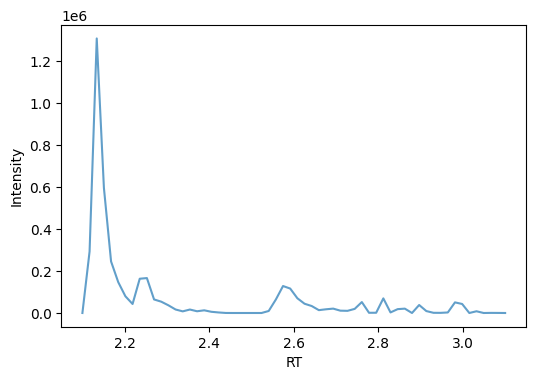

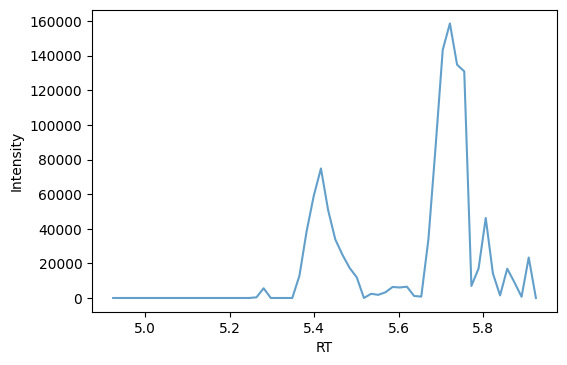

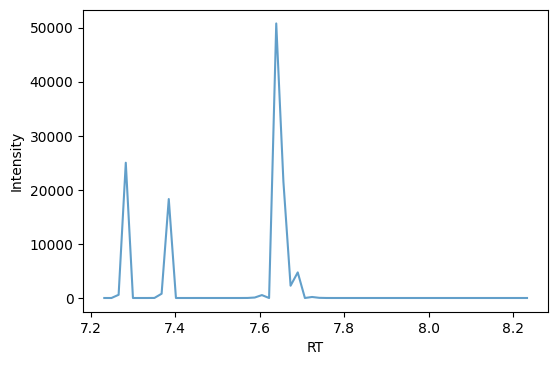

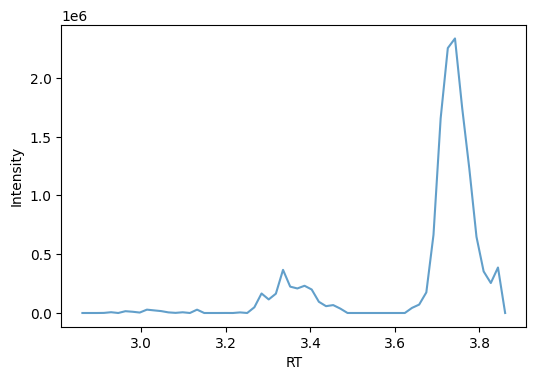

<Figure size 600x400 with 0 Axes>

In [125]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

In [126]:
xcmsCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" not in x]
xcms_peak_areas = peak_intensities[xcmsCols]
xcms_peak_areas

,QC_01.mzML,QC_02.mzML,QC_03.mzML,QC_04.mzML,QC_05.mzML,QC_06.mzML,QC_07.mzML
FT00001,1.974936e+06,1.858493e+06,1.798871e+06,1.757297e+06,1.773365e+06,1.768485e+06,2.304243e+06
FT00002,2.826669e+07,2.815197e+07,2.841696e+07,2.881003e+07,3.145220e+07,3.074870e+07,3.318160e+07
FT00003,8.213799e+06,9.725321e+06,9.307397e+06,7.713435e+06,8.139520e+06,7.220048e+06,8.205855e+06
FT00004,3.205281e+05,3.206047e+05,2.857381e+05,3.124773e+05,3.306725e+05,3.484202e+05,3.416744e+05
FT00005,2.072345e+05,1.836083e+05,2.224421e+05,1.704847e+05,2.148285e+05,1.860289e+05,2.334494e+05
...,...,...,...,...,...,...,...
FT32177,1.895676e+04,0.000000e+00,1.190416e+05,1.293768e+04,7.919847e+04,0.000000e+00,2.039624e+05
FT32178,7.459506e+04,1.379095e+05,1.272461e+05,1.030717e+05,1.344736e+05,1.053646e+05,7.916662e+04
FT32179,1.857563e+05,1.975252e+05,2.361436e+05,2.210434e+05,2.238891e+05,2.395129e+05,2.108537e+05
FT32180,1.741973e+05,1.996532e+05,1.700717e+05,1.492381e+05,2.215041e+05,1.772771e+05,2.104139e+05


In [127]:
pdCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" in x]
pd_peak_areas = peak_intensities[pdCols]
pd_peak_areas

,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_01.mzML,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_02.mzML,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_03.mzML,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_04.mzML,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_05.mzML,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_06.mzML,D:/PeakDetective/data/ST001882_GT_RP_Positive/QC_07.mzML
FT00001,1.770561e+06,2.008296e+06,1.659026e+06,1.705139e+06,1.653035e+06,1.473766e+06,1.824713e+06
FT00002,2.568283e+07,2.394791e+07,2.556129e+07,2.652860e+07,2.814166e+07,2.730832e+07,3.140231e+07
FT00003,4.762837e+06,4.941783e+06,4.356988e+06,3.887249e+06,4.938783e+06,3.779513e+06,3.561490e+06
FT00004,3.276755e+05,2.622989e+05,2.428972e+05,3.643616e+05,2.980086e+05,2.615743e+05,2.975209e+05
FT00005,1.296042e+05,1.401095e+05,1.802996e+05,1.282977e+05,1.462846e+05,1.276851e+05,1.028525e+05
...,...,...,...,...,...,...,...
FT32177,0.000000e+00,5.157589e+04,0.000000e+00,0.000000e+00,4.890063e+04,6.855439e+04,2.282436e+05
FT32178,5.973065e+04,1.556282e+05,1.380368e+05,0.000000e+00,1.571294e+05,1.170988e+05,8.062427e+04
FT32179,2.176156e+05,2.059655e+05,2.192636e+05,2.151174e+05,2.106176e+05,1.942074e+05,2.248658e+05
FT32180,1.812835e+05,1.917104e+05,1.818603e+05,1.425529e+05,2.561885e+05,2.112294e+05,1.730770e+05


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


0.5155145037651298

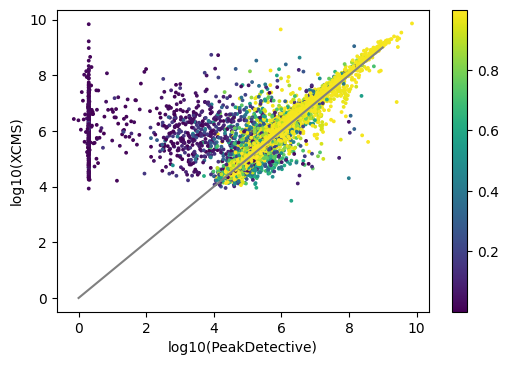

In [128]:
plt.scatter(np.log10(pd_peak_areas.values.mean(axis=1)+2),np.log10(xcms_peak_areas.values.mean(axis=1)),s=3,c=peak_scores[pdCols].values.mean(axis=1))
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(PeakDetective)")
plt.ylabel("log10(XCMS)")
plt.colorbar()
met.r2_score(pd_peak_areas.values.mean(axis=1),xcms_peak_areas.values.mean(axis=1))